# Importación Librerias y Datasets

In [ ]:
from pathlib import Path
from datetime import datetime

run_dir = Path("artifacts/catboost_info") / datetime.now().strftime("%Y%m%d-%H%M%S")
run_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
import numpy as np
import pandas as pd

# # fechas
# import datetime as dt
# from datetime import datetime
# from dateutil.relativedelta import relativedelta

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# modelos
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier # Stochastic Gradient Descent Classifier: el equivalente del Adaline
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

# metricas
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# interpretabilidad
import shap

# para visualizar mas columnas en un df
pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings("ignore")  # inhabilita warnings

np.random.seed(42)

In [ ]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Modelos

## 1. Modelo Productos Cuenta

### DF Cuenta

In [131]:
# Cargamos los datasets desde archivos pickle

df_train_cuenta = pd.read_pickle("pickle/df_train_cuenta.pkl")
df_pred_cuenta = pd.read_pickle("pickle/df_pred_cuenta.pkl")
df_ids_predecir_cuenta = pd.read_pickle("pickle/df_ids_predecir_cuenta.pkl")
df_ids_predecir_ahorro = pd.read_pickle("pickle/df_ids_predecir_ahorro.pkl")
df_ids_predecir_finan = pd.read_pickle("pickle/df_ids_predecir_finan.pkl")


In [132]:
# Reemplazamos valores negativos en la columna 'days_since_entry' por 0

df_train_cuenta['days_since_entry'] = df_train_cuenta['days_since_entry'].apply(lambda x: 0 if x < 0 else x)
df_pred_cuenta['days_since_entry'] = df_pred_cuenta['days_since_entry'].apply(lambda x: 0 if x < 0 else x)

In [133]:
# Definimos la target para el modelo de cuenta

target_prod_cuenta = 'tiene_prod_cuenta_lead1'

In [134]:
# Eliminamos las columnas innecesarias del dataframe de predicción y entrenamiento

del(df_pred_cuenta[target_prod_cuenta])
del(df_pred_cuenta['total_sin_tiene_prod_cuenta'])
del(df_train_cuenta['total_sin_tiene_prod_cuenta'])


### 1.1 Features Importance

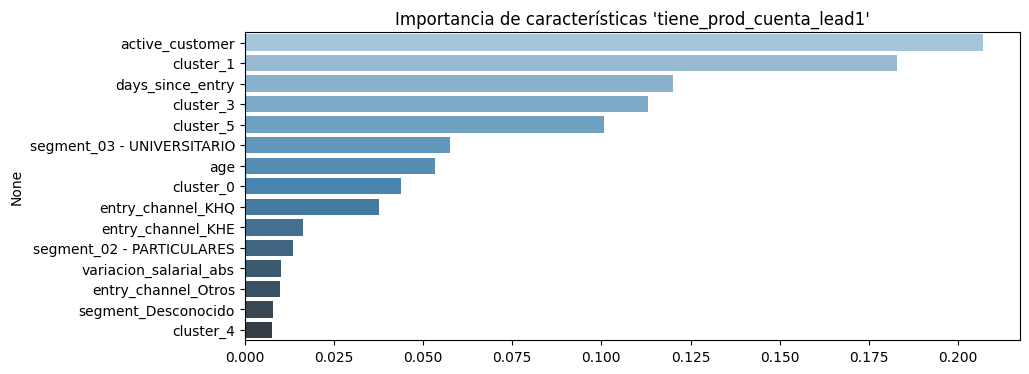

Identificamos y graficamos las 15 características más importantes según su contribución al modelo, ordenadas de mayor a menor.


In [135]:
# Definimos los parámetros para el RandomForestClassifier
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

# Separamos las características (X) y la variable objetivo (y)
x, y = df_train_cuenta.drop(target_prod_cuenta, axis=1), df_train_cuenta[target_prod_cuenta]

# Entrenamos un RandomForestClassifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)

# Obtenemos las 15 características más importantes
num_features = 15
features = clf.feature_importances_
columnas = x.columns
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)[:num_features]

# Graficamos las 15 características más importantes
plt.figure(figsize=(10, 4))
plt.title("Importancia de características '{}'".format(target_prod_cuenta))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')
plt.show()

print("Identificamos y graficamos las 15 características más importantes según su contribución al modelo, ordenadas de mayor a menor.")

### 1.2 Split X-y

In [136]:
df_train_cuenta

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,entry_channel_KAT,entry_channel_KFC,entry_channel_KHE,entry_channel_KHQ,entry_channel_Otros,gender_V,long_term_deposit,region_name_Albacete,region_name_Alicante/Alacant,region_name_Asturias,region_name_Badajoz,"region_name_Balears, Illes",region_name_Barcelona,region_name_Cantabria,region_name_Castellón/Castelló,region_name_Ciudad Real,"region_name_Coruña, A",region_name_Cádiz,region_name_Córdoba,region_name_Granada,region_name_Huelva,region_name_Madrid,region_name_Murcia,region_name_Málaga,region_name_Otros,"region_name_Palmas, Las",region_name_Pontevedra,region_name_Salamanca,region_name_Sevilla,region_name_Toledo,region_name_Valencia/València,region_name_Valladolid,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,tiene_prod_cuenta_lead1,variacion_salarial_abs
0,1,58,1,0,0,0,0,0,89,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,180256.629898,0.0,0,1,0,0,0,1.0,45690.165071
1,1,53,0,0,0,0,0,1,346,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,102405.750000,0.0,0,1,0,0,0,1.0,0.000000
2,1,65,1,0,0,0,0,0,64,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,175951.518283,0.0,1,0,0,0,0,1.0,49392.147829
3,1,75,1,0,0,0,0,0,65,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,144736.162150,0.0,0,1,0,0,0,1.0,33444.880150
4,1,53,0,0,0,0,0,1,566,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,168943.230000,0.0,0,1,0,0,0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183123,1,46,0,0,0,0,0,1,650,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,80434.500000,0.0,0,1,0,0,0,0.0,0.000000
52050,0,23,0,1,0,0,0,0,1303,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,465699.720000,0.0,0,0,1,0,0,0.0,0.000000
362354,0,22,0,0,1,0,0,0,183,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,194534.486750,0.0,0,0,1,0,0,0.0,24248.462514
135239,0,31,0,0,0,1,0,0,932,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,79113.570000,0.0,0,1,0,0,0,0.0,0.000000


In [137]:
# Guardamos la target como 'y' y las features como 'X'
y = df_train_cuenta[target_prod_cuenta]
X = df_train_cuenta.drop(target_prod_cuenta, axis=1)

print("Guardamos la target como 'y' y las features como 'X'")

Guardamos la target como 'y' y las features como 'X'


### 1.3 Rescaling

In [138]:
X

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,entry_channel_KAT,entry_channel_KFC,entry_channel_KHE,entry_channel_KHQ,entry_channel_Otros,gender_V,long_term_deposit,region_name_Albacete,region_name_Alicante/Alacant,region_name_Asturias,region_name_Badajoz,"region_name_Balears, Illes",region_name_Barcelona,region_name_Cantabria,region_name_Castellón/Castelló,region_name_Ciudad Real,"region_name_Coruña, A",region_name_Cádiz,region_name_Córdoba,region_name_Granada,region_name_Huelva,region_name_Madrid,region_name_Murcia,region_name_Málaga,region_name_Otros,"region_name_Palmas, Las",region_name_Pontevedra,region_name_Salamanca,region_name_Sevilla,region_name_Toledo,region_name_Valencia/València,region_name_Valladolid,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,variacion_salarial_abs
0,1,58,1,0,0,0,0,0,89,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,180256.629898,0.0,0,1,0,0,0,45690.165071
1,1,53,0,0,0,0,0,1,346,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,102405.750000,0.0,0,1,0,0,0,0.000000
2,1,65,1,0,0,0,0,0,64,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,175951.518283,0.0,1,0,0,0,0,49392.147829
3,1,75,1,0,0,0,0,0,65,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,144736.162150,0.0,0,1,0,0,0,33444.880150
4,1,53,0,0,0,0,0,1,566,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,168943.230000,0.0,0,1,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183123,1,46,0,0,0,0,0,1,650,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,80434.500000,0.0,0,1,0,0,0,0.000000
52050,0,23,0,1,0,0,0,0,1303,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,465699.720000,0.0,0,0,1,0,0,0.000000
362354,0,22,0,0,1,0,0,0,183,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,194534.486750,0.0,0,0,1,0,0,24248.462514
135239,0,31,0,0,0,1,0,0,932,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,79113.570000,0.0,0,1,0,0,0,0.000000


In [139]:
df_pred_cuenta

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,entry_channel_KAT,entry_channel_KFC,entry_channel_KHE,entry_channel_KHQ,entry_channel_Otros,gender_V,long_term_deposit,region_name_Albacete,region_name_Alicante/Alacant,region_name_Asturias,region_name_Badajoz,"region_name_Balears, Illes",region_name_Barcelona,region_name_Cantabria,region_name_Castellón/Castelló,region_name_Ciudad Real,"region_name_Coruña, A",region_name_Cádiz,region_name_Córdoba,region_name_Granada,region_name_Huelva,region_name_Madrid,region_name_Murcia,region_name_Málaga,region_name_Otros,"region_name_Palmas, Las",region_name_Pontevedra,region_name_Salamanca,region_name_Sevilla,region_name_Toledo,region_name_Valencia/València,region_name_Valladolid,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,variacion_salarial_abs
0,0,62,1,0,0,0,0,0,190,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,160980.198311,0.0,0,1,0,0,0,19766.346572
1,1,70,1,0,0,0,0,0,156,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152841.136667,0.0,1,0,0,0,0,-101780.208333
2,1,55,1,0,0,0,0,0,891,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,407281.110000,0.0,0,1,0,0,0,0.000000
3,1,47,0,0,0,0,1,0,509,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,84511.860000,0.0,0,1,0,0,0,0.000000
4,1,78,0,0,0,0,1,0,389,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,282461.790000,0.0,1,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370399,0,52,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52673.925000,0.0,0,0,0,1,0,0.000000
370400,0,30,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,113105.705172,0.0,0,0,0,1,0,0.000000
370401,0,21,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,170286.024236,0.0,0,0,0,1,0,0.000000
370402,0,43,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,355549.267500,0.0,0,0,0,1,0,0.000000


In [140]:
df_pred_cuenta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370404 entries, 0 to 370403
Data columns (total 50 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   active_customer                 370404 non-null  int16  
 1   age                             370404 non-null  int16  
 2   cluster_0                       370404 non-null  int32  
 3   cluster_1                       370404 non-null  int32  
 4   cluster_2                       370404 non-null  int32  
 5   cluster_3                       370404 non-null  int32  
 6   cluster_4                       370404 non-null  int32  
 7   cluster_5                       370404 non-null  int32  
 8   days_since_entry                370404 non-null  int64  
 9   entry_channel_KAT               370404 non-null  int32  
 10  entry_channel_KFC               370404 non-null  int32  
 11  entry_channel_KHE               370404 non-null  int32  
 12  entry_channel_KH

In [141]:
df_train_cuenta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64866 entries, 0 to 12677
Data columns (total 51 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   active_customer                 64866 non-null  int16  
 1   age                             64866 non-null  int16  
 2   cluster_0                       64866 non-null  int32  
 3   cluster_1                       64866 non-null  int32  
 4   cluster_2                       64866 non-null  int32  
 5   cluster_3                       64866 non-null  int32  
 6   cluster_4                       64866 non-null  int32  
 7   cluster_5                       64866 non-null  int32  
 8   days_since_entry                64866 non-null  int64  
 9   entry_channel_KAT               64866 non-null  int32  
 10  entry_channel_KFC               64866 non-null  int32  
 11  entry_channel_KHE               64866 non-null  int32  
 12  entry_channel_KHQ               64866

In [142]:
# Guardamos las columnas del dataset en una lista antes de estandarizar
# El método scaler quita el nombre de las variables
# Para la interpretabilidad, si el modelo ganador es un árbol de decisión, conviene guardar el nombre de las variables

variables_entrenadas_cuenta = X.columns
variables_entrenadas_cuenta

Index(['active_customer', 'age', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'days_since_entry',
       'entry_channel_KAT', 'entry_channel_KFC', 'entry_channel_KHE',
       'entry_channel_KHQ', 'entry_channel_Otros', 'gender_V',
       'long_term_deposit', 'region_name_Albacete',
       'region_name_Alicante/Alacant', 'region_name_Asturias',
       'region_name_Badajoz', 'region_name_Balears, Illes',
       'region_name_Barcelona', 'region_name_Cantabria',
       'region_name_Castellón/Castelló', 'region_name_Ciudad Real',
       'region_name_Coruña, A', 'region_name_Cádiz', 'region_name_Córdoba',
       'region_name_Granada', 'region_name_Huelva', 'region_name_Madrid',
       'region_name_Murcia', 'region_name_Málaga', 'region_name_Otros',
       'region_name_Palmas, Las', 'region_name_Pontevedra',
       'region_name_Salamanca', 'region_name_Sevilla', 'region_name_Toledo',
       'region_name_Valencia/València', 'region_name_Valladolid',
    

In [143]:
# Se estandarizan las variables
scaler = StandardScaler()
X = scaler.fit_transform(X)   # Estandariza y define la regla de estandarización
df_pred_cuenta=scaler.transform(df_pred_cuenta) # Estandariza según la regla definida con el X_train, con la media de X_train

### 1.4 Split TRAIN-TEST

In [144]:
# Se utilizan 70% de los datos para entrenar el modelo y se guardan 30% de los datos para evaluar el modelo (de forma aleatoria)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [145]:
print('El nº observaciones del df de train es de:', len(y_train))
print('El nº observaciones del df de test es de:', len(y_test))

El nº observaciones del df de train es de: 45406
El nº observaciones del df de test es de: 19460


In [146]:
# Convertimos el conjunto de prueba (X_test) en un DataFrame y asignamos los nombres de las columnas originales
df_X_test = pd.DataFrame(X_test, columns=variables_entrenadas_cuenta)

df_X_test

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,entry_channel_KAT,entry_channel_KFC,entry_channel_KHE,entry_channel_KHQ,entry_channel_Otros,gender_V,long_term_deposit,region_name_Albacete,region_name_Alicante/Alacant,region_name_Asturias,region_name_Badajoz,"region_name_Balears, Illes",region_name_Barcelona,region_name_Cantabria,region_name_Castellón/Castelló,region_name_Ciudad Real,"region_name_Coruña, A",region_name_Cádiz,region_name_Córdoba,region_name_Granada,region_name_Huelva,region_name_Madrid,region_name_Murcia,region_name_Málaga,region_name_Otros,"region_name_Palmas, Las",region_name_Pontevedra,region_name_Salamanca,region_name_Sevilla,region_name_Toledo,region_name_Valencia/València,region_name_Valladolid,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,short_term_deposit,variacion_salarial_abs
0,0.544319,0.165489,1.423387,-0.22509,-0.274202,-0.307451,-0.343699,-0.748978,-0.420134,-0.302317,-0.427275,-0.71101,-0.254094,1.317720,0.909879,-0.144182,-0.102698,-0.193368,-0.143008,-0.113291,-0.105796,-0.300979,-0.123469,-0.103538,-0.106242,-0.18015,6.246282,-0.111604,-0.136647,-0.101387,-0.595856,-0.197829,-0.180014,-0.390954,-0.143512,-0.15506,-0.122175,-0.231445,-0.131402,-0.246126,-0.141485,-0.13243,-0.182944,-0.055558,-0.243579,1.047046,-0.783187,-0.308261,-0.144627,-0.029434
1,0.544319,-0.890126,1.423387,-0.22509,-0.274202,-0.307451,-0.343699,-0.748978,-0.940617,-0.302317,-0.427275,-0.71101,3.935551,-0.758887,0.909879,-0.144182,-0.102698,-0.193368,-0.143008,-0.113291,-0.105796,-0.300979,-0.123469,-0.103538,-0.106242,-0.18015,-0.160095,-0.111604,-0.136647,-0.101387,1.678257,-0.197829,-0.180014,-0.390954,-0.143512,-0.15506,-0.122175,-0.231445,-0.131402,-0.246126,-0.141485,-0.13243,0.324945,4.017849,-0.243579,-0.955068,1.276835,-0.308261,-0.144627,2.020150
2,-1.837159,-0.513120,-0.702550,-0.22509,3.646953,-0.307451,-0.343699,-0.748978,-0.695684,-0.302317,2.340413,-0.71101,-0.254094,-0.758887,0.909879,-0.144182,-0.102698,5.171482,-0.143008,-0.113291,-0.105796,-0.300979,-0.123469,-0.103538,-0.106242,-0.18015,-0.160095,-0.111604,-0.136647,-0.101387,-0.595856,-0.197829,-0.180014,-0.390954,-0.143512,-0.15506,-0.122175,-0.231445,-0.131402,-0.246126,-0.141485,-0.13243,-0.187556,-0.055558,-0.243579,1.047046,-0.783187,-0.308261,-0.144627,-0.029434
3,0.544319,0.391692,-0.702550,-0.22509,-0.274202,-0.307451,2.909526,-0.748978,-0.662516,-0.302317,-0.427275,-0.71101,-0.254094,1.317720,0.909879,-0.144182,-0.102698,-0.193368,-0.143008,-0.113291,-0.105796,-0.300979,-0.123469,-0.103538,-0.106242,-0.18015,-0.160095,-0.111604,-0.136647,-0.101387,-0.595856,-0.197829,-0.180014,2.557842,-0.143512,-0.15506,-0.122175,-0.231445,-0.131402,-0.246126,-0.141485,-0.13243,-0.131261,-0.055558,-0.243579,1.047046,-0.783187,-0.308261,-0.144627,-0.029434
4,0.544319,-0.965527,-0.702550,-0.22509,-0.274202,-0.307451,-0.343699,1.335153,0.850455,-0.302317,2.340413,-0.71101,-0.254094,-0.758887,-1.099047,-0.144182,-0.102698,-0.193368,-0.143008,-0.113291,-0.105796,-0.300979,-0.123469,-0.103538,-0.106242,-0.18015,-0.160095,-0.111604,-0.136647,-0.101387,-0.595856,-0.197829,-0.180014,-0.390954,-0.143512,-0.15506,-0.122175,-0.231445,-0.131402,4.062966,-0.141485,-0.13243,-0.135395,-0.055558,-0.243579,-0.955068,1.276835,-0.308261,-0.144627,-0.029434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19455,0.544319,0.617896,-0.702550,-0.22509,-0.274202,-0.307451,-0.343699,1.335153,2.195035,-0.302317,2.340413,-0.71101,-0.254094,-0.758887,0.909879,-0.144182,-0.102698,-0.193368,-0.143008,-0.113291,-0.105796,-0.300979,-0.123469,-0.103538,-0.106242,-0.18015,-0.160095,-0.111604,-0.136647,-0.101387,-0.595856,-0.197829,-0.180014,2.557842,-0.143512,-0.15506,-0.122175,-0.231445,-0.131402,-0.24

### 1.5 Torneo de modelos

In [ ]:
# Definimos una lista vacía para almacenar los modelos
modelos = []

# Añadimos los siguientes modelos a la lista de modelos:
modelos.append(('Perceptron', Perceptron(random_state=42)))
modelos.append(('SGDClassifier', SGDClassifier(loss='log_loss', random_state=42)))
modelos.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)))
modelos.append(('XGBClassifier', XGBClassifier(random_state=42, verbosity=0)))
modelos.append((
    'CatBoostClassifier',
    CatBoostClassifier(verbose=False, random_seed=42, train_dir=str(run_dir))
))
modelos.append(('LogisticRegression', LogisticRegression(random_state=42)))

In [148]:
# Creamos un DataFrame vacío para almacenar las métricas de los modelos
metricas_modelos = pd.DataFrame(columns=['modelo', 'AUC'])

# Iteramos sobre la lista de modelos y entrenamos el modelo:
for nombre, modelo in modelos:
  modelo.fit(X_train, y_train)

  # Hacemos la predicción sobre el dataset de test
  # El AUC se calcula con predict_proba.
  # Para el Perceptron, usaremos decision_function, el equivalente de predict_proba para este algoritmo
  if nombre == 'Perceptron':
    y_pred = modelo.decision_function(X_test)
  else:
    y_pred = modelo.predict_proba(X_test)[:, 1]

  # Calculamos el AUC
  auc = metrics.roc_auc_score(y_test, y_pred)

  # Imprimimos el resultado por modelo
  metricas_modelos = pd.concat([metricas_modelos,
                  pd.DataFrame({'modelo': nombre, 'AUC': auc}, index=[0])
                  ])
  print(modelo, auc)

# Ordenamos los modelos por AUC de forma descendente
metricas_modelos.sort_values('AUC', ascending=False)

Perceptron(random_state=42) 0.823985727990135
SGDClassifier(loss='log_loss', random_state=42) 0.9107826897787308
GradientBoostingClassifier(random_state=42) 0.9321077199134872
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...) 0.9379889081111338
<catboost.core.CatBoostClassifier object at 0x000

,modelo,AUC
0,CatBoostClassifier,0.940198
0,XGBClassifier,0.937989
0,GradientBoostingClassifier,0.932108
0,LogisticRegression,0.912019
0,SGDClassifier,0.910783
0,Perceptron,0.823986


In [149]:
# Ordenamos los modelos por AUC de forma descendente
metricas_modelos = metricas_modelos.sort_values('AUC', ascending=False)

# Seleccionamos el modelo ganador (el que tiene el AUC más alto)
modelo_ganador = metricas_modelos.iloc[0]
nombre_modelo_ganador = modelo_ganador['modelo']
auc_modelo_ganador = modelo_ganador['AUC']

# Imprimimos el resultado
print("El modelo ganador es {} con un AUC de {:.3f}".format(nombre_modelo_ganador, auc_modelo_ganador))

El modelo ganador es CatBoostClassifier con un AUC de 0.940


### 1.6 Modelado Final

In [150]:
# Selección del mejor modelo con los mejores parámetros, que son los estándar
modelo = CatBoostClassifier(verbose=False, random_state=42)

# Entrenamiento del modelo
modelo.fit(X_train, y_train)

# Imprimimos un mensaje indicando que el modelo ha sido entrenado con los parámetros estándar
print("Entrenamos el modelo con los parámetros estándar del modelo")

Entrenamos el modelo con los parámetros estándar del modelo


In [151]:
# Predicción en el dataset de entrenamiento
y_pred_train = modelo.predict_proba(X_train)

# Evaluación de la métrica
auc_train = metrics.roc_auc_score(y_train, y_pred_train[:,1])

# Imprimimos el AUC sobre el dataset de entrenamiento
print("El AUC sobre el df_train es de: {:.5f}".format(auc_train))


El AUC sobre el df_train es de: 0.96410


In [152]:
# Predicción en el dataset de test
y_pred_test = modelo.predict_proba(X_test)

# Evaluación de la métrica 
auc_test = metrics.roc_auc_score(y_test, y_pred_test[:,1])

# Imprimimos el resultado del AUC sobre el dataset de test
print("El AUC sobre el df_test es de: {:.5f}".format(auc_test))

El AUC sobre el df_test es de: 0.94020


In [153]:
# Importamos la función mutual_info_classif para la selección de características
# Esta función calcula la información mutua entre cada característica y la variable objetivo
from sklearn.feature_selection import mutual_info_classif

# Calculamos la información mutua entre las características (X_train) y la variable objetivo (y_train)
# La información mutua mide la dependencia entre las variables, es decir, cuánta información sobre la variable objetivo
mutual_info = mutual_info_classif(X_train, y_train)

# Imprimimos los valores de información mutua para cada característica
print(mutual_info)

[0.10528899 0.03780074 0.02258183 0.06508225 0.00412348 0.04769167
 0.00439852 0.05725468 0.13690647 0.00266492 0.00317959 0.01418576
 0.02530069 0.02215902 0.00466956 0.00421375 0.00146473 0.
 0.00099223 0.00033934 0.         0.00176142 0.         0.00036
 0.0014374  0.00365133 0.00097413 0.00356961 0.00293796 0.00171482
 0.00536729 0.         0.         0.00078752 0.00271158 0.0012284
 0.00071839 0.         0.0031571  0.00482783 0.00123627 0.00314181
 0.01873303 0.00535833 0.00613647 0.02293444 0.04274668 0.01212264
 0.00553447 0.02448809]


In [154]:
# Importamos la función cross_val_score para realizar validación cruzada
from sklearn.model_selection import cross_val_score

# Calculamos las puntuaciones AUC utilizando validación cruzada con 5 particiones
# cross_val_score entrena y evalúa el modelo en diferentes particiones de los datos
auc_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='roc_auc')

# Imprimimos la media de las puntuaciones AUC obtenidas
# Esto nos da una idea del rendimiento promedio del modelo en diferentes particiones de los datos
print(auc_scores.mean())

0.9386839730567825


AUC scores for each fold: [0.70471999 0.851356   0.89523421 0.90366999 0.87000424]
Mean AUC: 0.8449968871338281


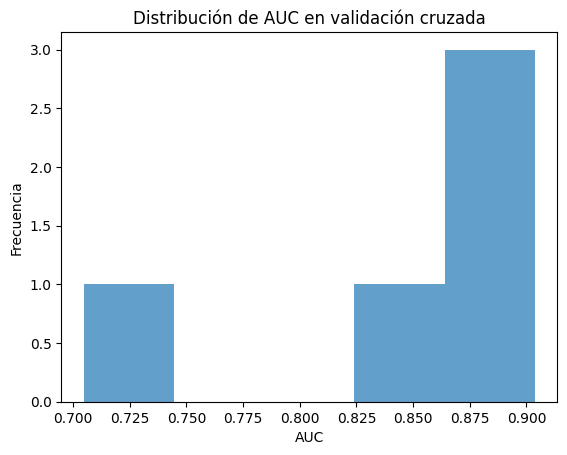

In [155]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Realizamos la validación cruzada utilizando la métrica AUC
# cross_val_score entrena y evalúa el modelo en diferentes particiones de los datos

auc_scores = cross_val_score(clf, x, y, cv=5, scoring='roc_auc')

# Imprimimos los AUC scores obtenidos en cada partición (fold)
print("AUC scores for each fold:", auc_scores)

# Calculamos e imprimimos la media de los AUC scores
print("Mean AUC:", auc_scores.mean())

# Visualizamos la distribución de los AUC scores utilizando un histograma

plt.hist(auc_scores, bins=5, alpha=0.7)
plt.title("Distribución de AUC en validación cruzada")
plt.xlabel("AUC")
plt.ylabel("Frecuencia")
plt.show()


### 1.7 INTERPRETABILITY

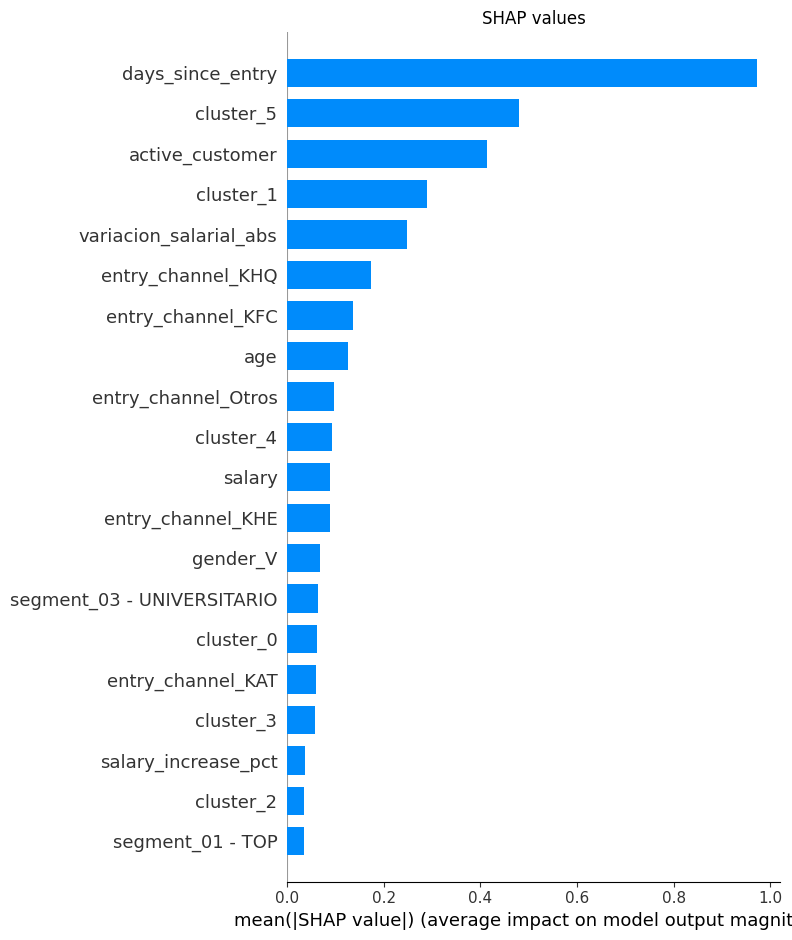

Las features más importantes según los valores SHAP son:
days_since_entry: 0.9713
cluster_5: 0.4802
active_customer: 0.4137
cluster_1: 0.2886
variacion_salarial_abs: 0.2477


In [156]:
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(df_X_test)

plt.title('SHAP values')

# Gráfico de resumen de los valores SHAP
shap.summary_plot(shap_values, df_X_test, plot_type="bar", max_display=20)

# Calcular la importancia promedio de cada característica (absoluta)
importancia_shap = pd.DataFrame({
    'feature': df_X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

# Seleccionar las 5 características más importantes
top_features = importancia_shap.head(5)

# Imprimir las características principales
print("Las features más importantes según los valores SHAP son:")
for i, row in top_features.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

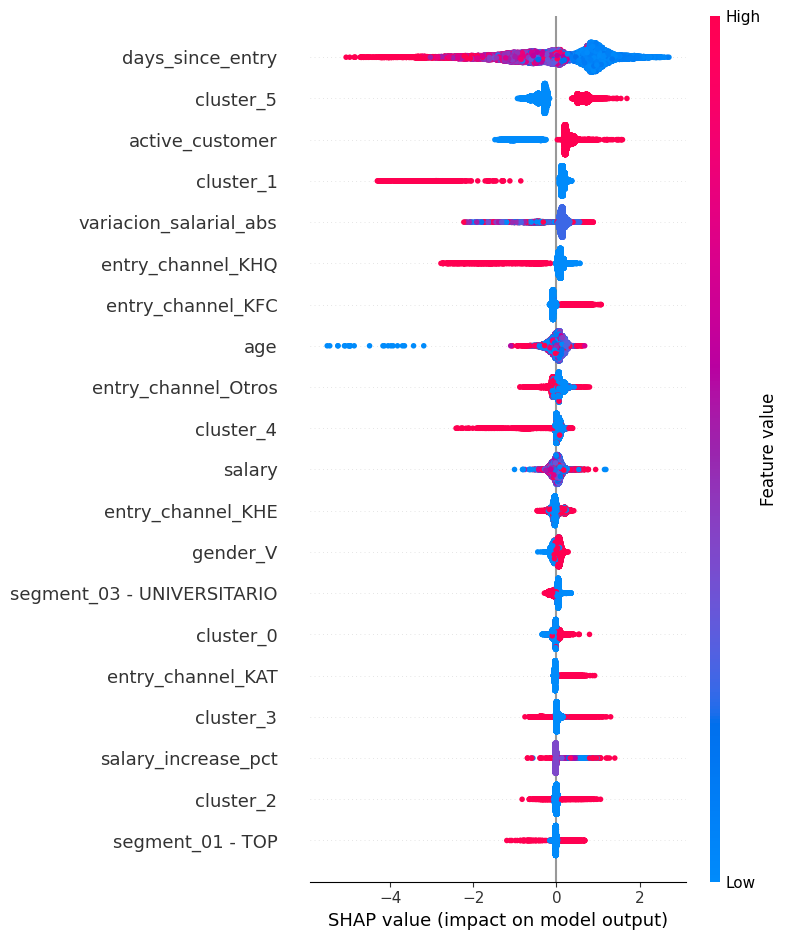

In [157]:
# Generamos el gráfico de resumen de los valores SHAP
shap.summary_plot(shap_values, df_X_test)

In [158]:
df_pred_cuenta

array([[-1.83715861,  2.05051576,  1.42338715, ..., -0.30826136,
        -0.14462692,  0.85265991],
       [ 0.54431882,  2.65372425,  1.42338715, ..., -0.30826136,
        -0.14462692, -4.57148537],
       [ 0.54431882,  1.52270832,  1.42338715, ..., -0.30826136,
        -0.14462692, -0.02943449],
       ...,
       [-1.83715861, -1.04092778, -0.70254955, ...,  3.24400043,
        -0.14462692, -0.02943449],
       [-1.83715861,  0.61789558, -0.70254955, ...,  3.24400043,
        -0.14462692, -0.02943449],
       [-1.83715861,  0.39169239, -0.70254955, ...,  3.24400043,
        -0.14462692, -0.02943449]])

### 1.8. Matriz de confusion 

In [159]:
# Convertimos las predicciones de test en un DataFrame
y_pred_test2 = pd.DataFrame(y_pred_test)

# Seleccionamos la segunda columna que contiene las probabilidades de la clase positiva
y_pred_test2 = y_pred_test2[1]

y_pred_test2

0        0.866968
1        0.995119
2        0.988414
3        0.989561
4        0.973521
           ...   
19455    0.981012
19456    0.545719
19457    0.747734
19458    0.936750
19459    0.987973
Name: 1, Length: 19460, dtype: float64

In [160]:
# Convertimos las probabilidades de predicción en etiquetas binarias (0 o 1)
# Si la probabilidad es mayor o igual a 0.5, se asigna 1, de lo contrario se asigna 0
y_pred_test2 = (y_pred_test2 >= 0.5).astype(int)

# Mostramos las etiquetas binarias resultantes
y_pred_test2

0        1
1        1
2        1
3        1
4        1
        ..
19455    1
19456    1
19457    1
19458    1
19459    1
Name: 1, Length: 19460, dtype: int32

In [161]:
# Imprimimos las primeras 5 observaciones de y_test
print("y_test:", y_test[:5])

# Imprimimos las primeras 5 predicciones de y_pred_test2
print("y_pred_test:", y_pred_test2[:5])


y_test: 37343    1.0
45305    1.0
22519    1.0
25925    1.0
11605    1.0
Name: tiene_prod_cuenta_lead1, dtype: float64
y_pred_test: 0    1
1    1
2    1
3    1
4    1
Name: 1, dtype: int32


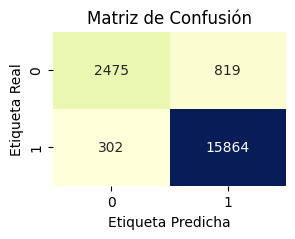

In [162]:
# creamos la matriz de confusión
cm = metrics.confusion_matrix(y_test, y_pred_test2)

plt.figure(figsize=(3,2))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)

plt.title('Matriz de Confusión')

plt.xlabel('Etiqueta Predicha')

plt.ylabel('Etiqueta Real')

# mostramos el gráfico
plt.show()

### 1.9. Curva ROC

In [163]:
# Convertimos las predicciones del conjunto de entrenamiento en un DataFrame
y_pred_train2 = pd.DataFrame(y_pred_train)

# Seleccionamos la segunda columna que contiene las probabilidades de la clase positiva
y_pred_train2 = y_pred_train2[1]

# Mostramos las probabilidades de la clase positiva
y_pred_train2

0        0.003422
1        0.956286
2        0.961063
3        0.980821
4        0.992914
           ...   
45401    0.909543
45402    0.950573
45403    0.983666
45404    0.955794
45405    0.003214
Name: 1, Length: 45406, dtype: float64

In [164]:
# Convertimos las probabilidades de predicción en etiquetas binarias (0 o 1)
# Si la probabilidad es mayor o igual a 0.5, se asigna 1, de lo contrario se asigna 0
y_pred_train2 = (y_pred_train2 >= 0.5).astype(int)

# Mostramos las etiquetas binarias resultantes
y_pred_train2

0        0
1        1
2        1
3        1
4        1
        ..
45401    1
45402    1
45403    1
45404    1
45405    0
Name: 1, Length: 45406, dtype: int32

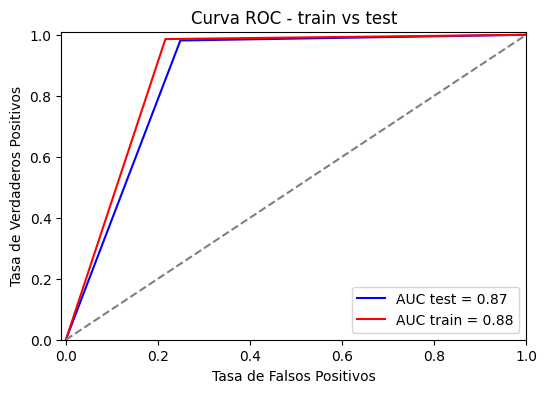

In [165]:
# Métricas de test
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test, y_pred_test2)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# Métricas de train
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, y_pred_train2)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Generamos el gráfico
plt.figure(figsize=(6, 4))

# Curva ROC para el conjunto de test
plt.plot(fpr_test, tpr_test, 'b', label=f'AUC test = {roc_auc_test:.2f}')

# Curva ROC para el conjunto de train
plt.plot(fpr_train, tpr_train, 'r', label=f'AUC train = {roc_auc_train:.2f}')

plt.title('Curva ROC - train vs test')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')

# Mostrar el gráfico
plt.show()


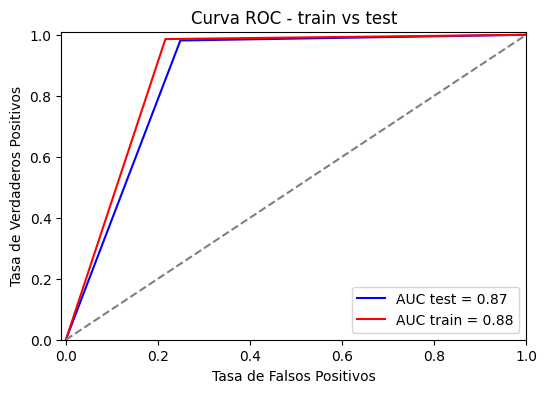

In [166]:
# Métricas de test
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test, y_pred_test2)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# Métricas de train
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, y_pred_train2)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Generamos el gráfico
plt.figure(figsize=(6, 4))

# Curva ROC para el conjunto de test
plt.plot(fpr_test, tpr_test, 'b', label='AUC test = %0.2f' % roc_auc_test)

# Curva ROC para el conjunto de train
plt.plot(fpr_train, tpr_train, 'r', label='AUC train = %0.2f' % roc_auc_train)

plt.title('Curva ROC - train vs test')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('Tasa de Verdaderos Positivos')
plt.xlabel('Tasa de Falsos Positivos')

# Mostrar el gráfico
plt.show()

### 1.10. Predict

In [167]:
# Creamos un array con las predicciones del modelo (en unos y ceros)
pred = modelo.predict(df_pred_cuenta)
pred_proba = modelo.predict_proba(df_pred_cuenta)
print(f' El resultado del la predicción esta en formato array', '\n',  pred_proba)

 El resultado del la predicción esta en formato array 
 [[0.36834165 0.63165835]
 [0.05700189 0.94299811]
 [0.05512995 0.94487005]
 ...
 [0.97000962 0.02999038]
 [0.93416657 0.06583343]
 [0.93507204 0.06492796]]


In [168]:
df_ids_predecir_cuenta 

,pk_cid,pk_partition
0,16063,2019-05-28
1,16203,2019-05-28
2,17590,2019-05-28
3,17799,2019-05-28
4,17980,2019-05-28
...,...,...
370399,1553685,2019-05-28
370400,1553686,2019-05-28
370401,1553687,2019-05-28
370402,1553688,2019-05-28


In [169]:
# Seleccionamos el ID del cliente del dataframe df_ids_predecir_cuenta
customer_id = df_ids_predecir_cuenta['pk_cid'] 

In [170]:
pred_proba = pd.DataFrame(pred_proba)
pred_proba

,0,1
0,0.368342,0.631658
1,0.057002,0.942998
2,0.055130,0.944870
3,0.173702,0.826298
4,0.596073,0.403927
...,...,...
370399,0.975910,0.024090
370400,0.946673,0.053327
370401,0.970010,0.029990
370402,0.934167,0.065833


In [171]:
# Creamos un dataframe con las predicciones y las probabilidades
df_prediccion_cuenta = pd.DataFrame()

# Asignamos el ID del cliente al dataframe
df_prediccion_cuenta['Customer_ID'] = customer_id

# Asignamos las predicciones al dataframe
df_prediccion_cuenta['prediccion'] = pred

# Asignamos las probabilidades de predicción al dataframe
df_prediccion_cuenta['%_proba'] = pred_proba[1]

# Imprimimos un mensaje indicando que podemos ver la predicción de cada cliente junto a la probabilidad de la predicción
print('Podemos ver la prediccion de cada cliente junto a la probabilidad de la prediccion')

# Mostramos el dataframe resultante
df_prediccion_cuenta

Podemos ver la prediccion de cada cliente junto a la probabilidad de la prediccion


,Customer_ID,prediccion,%_proba
0,16063,1.0,0.631658
1,16203,1.0,0.942998
2,17590,1.0,0.944870
3,17799,1.0,0.826298
4,17980,0.0,0.403927
...,...,...,...
370399,1553685,0.0,0.024090
370400,1553686,0.0,0.053327
370401,1553687,0.0,0.029990
370402,1553688,0.0,0.065833


In [172]:
df_prediccion_cuenta

,Customer_ID,prediccion,%_proba
0,16063,1.0,0.631658
1,16203,1.0,0.942998
2,17590,1.0,0.944870
3,17799,1.0,0.826298
4,17980,0.0,0.403927
...,...,...,...
370399,1553685,0.0,0.024090
370400,1553686,0.0,0.053327
370401,1553687,0.0,0.029990
370402,1553688,0.0,0.065833


In [173]:
df_prediccion_cuenta['prediccion'].value_counts()

prediccion
0.0    290353
1.0     80051
Name: count, dtype: int64

In [174]:
# Filtramos el dataframe para quedarnos solo con las predicciones cuya probabilidad es mayor al 50%
df_prediccion_cuenta = df_prediccion_cuenta[df_prediccion_cuenta['%_proba'] > 0.5]

### 1.11. Pickle Predicciones Modelo Cuenta

In [175]:
# Guardamos el dataframe de predicciones en un archivo CSV
df_prediccion_cuenta.to_csv('reports/predicciones_prod_cuenta.csv')

## 2. Modelo Productos Ahorro

### DF Ahorro

In [176]:
# Cargamos los datasets desde archivos pickle
df_train_ahorro = pd.read_pickle("pickle/df_train_ahorro.pkl")
df_pred_ahorro = pd.read_pickle("pickle/df_pred_ahorro.pkl")

In [177]:
df_train_ahorro

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,days_since_entry,em_acount,emc_account,entry_channel_KAT,entry_channel_KFC,entry_channel_KHE,entry_channel_KHQ,entry_channel_Otros,gender_V,payroll_account,region_name_Albacete,region_name_Alicante/Alacant,region_name_Asturias,region_name_Badajoz,"region_name_Balears, Illes",region_name_Barcelona,region_name_Cantabria,region_name_Castellón/Castelló,"region_name_Coruña, A",region_name_Cáceres,region_name_Cádiz,region_name_Córdoba,region_name_Granada,region_name_Huelva,region_name_Madrid,region_name_Murcia,region_name_Málaga,region_name_Otros,"region_name_Palmas, Las",region_name_Pontevedra,region_name_Salamanca,region_name_Sevilla,region_name_Toledo,region_name_Valencia/València,region_name_Valladolid,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_lead1,total_sin_tiene_prod_ahorro_inv,variacion_salarial_abs
0,1,53,0,0,0,0,0,1,0,407,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,102405.750000,0.0,0,1,0,0,1.0,2,0.000000
1,0,81,1,0,0,0,0,0,0,1076,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80161.620000,0.0,0,1,0,0,1.0,0,0.000000
2,1,64,1,0,0,0,0,0,0,23,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,112952.168691,0.0,0,0,0,1,1.0,3,0.000000
3,1,50,0,0,0,0,1,0,0,6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,138618.570000,0.0,0,1,0,0,1.0,1,0.000000
4,1,62,1,0,0,0,0,0,0,29,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,125530.410000,0.0,1,0,0,0,1.0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61395,0,30,0,0,0,1,0,0,0,1298,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,82381.500000,0.0,0,0,1,0,0.0,1,0.000000
166161,0,32,0,1,0,0,0,0,0,879,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93168.810000,0.0,0,0,1,0,0.0,2,0.000000
165733,0,22,1,0,0,0,0,0,0,729,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,99855.540000,0.0,0,0,1,0,0.0,2,0.000000
334460,0,29,0,1,0,0,0,0,0,115,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74029.074283,0.0,0,1,0,0,0.0,0,14925.271342


In [178]:
# Reemplazamos valores negativos en la columna 'days_since_entry' por 0 en el dataframe de entrenamiento
df_train_ahorro['days_since_entry'] = df_train_ahorro['days_since_entry'].apply(lambda x: 0 if x < 0 else x)

# Reemplazamos valores negativos en la columna 'days_since_entry' por 0 en el dataframe de predicción
df_pred_ahorro['days_since_entry'] = df_pred_ahorro['days_since_entry'].apply(lambda x: 0 if x < 0 else x)
# Reemplazamos valores negativos en la columna 'days_since_entry' por 0 en el dataframe de entrenamiento
df_train_ahorro['days_since_entry'] = df_train_ahorro['days_since_entry'].apply(lambda x: 0 if x < 0 else x)

# Reemplazamos valores negativos en la columna 'days_since_entry' por 0 en el dataframe de predicción
df_pred_ahorro['days_since_entry'] = df_pred_ahorro['days_since_entry'].apply(lambda x: 0 if x < 0 else x)

In [179]:
df_train_ahorro.columns

Index(['active_customer', 'age', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'credit_card',
       'days_since_entry', 'em_acount', 'emc_account', 'entry_channel_KAT',
       'entry_channel_KFC', 'entry_channel_KHE', 'entry_channel_KHQ',
       'entry_channel_Otros', 'gender_V', 'payroll_account',
       'region_name_Albacete', 'region_name_Alicante/Alacant',
       'region_name_Asturias', 'region_name_Badajoz',
       'region_name_Balears, Illes', 'region_name_Barcelona',
       'region_name_Cantabria', 'region_name_Castellón/Castelló',
       'region_name_Coruña, A', 'region_name_Cáceres', 'region_name_Cádiz',
       'region_name_Córdoba', 'region_name_Granada', 'region_name_Huelva',
       'region_name_Madrid', 'region_name_Murcia', 'region_name_Málaga',
       'region_name_Otros', 'region_name_Palmas, Las',
       'region_name_Pontevedra', 'region_name_Salamanca',
       'region_name_Sevilla', 'region_name_Toledo',
       'region_name_Valenc

In [180]:
# Eliminamos la columna 'total_sin_tiene_prod_ahorro_inv' del dataframe de entrenamiento
# Esta columna no es necesaria para el modelo y se elimina para evitar cualquier posible sesgo o redundancia en los datos
del(df_train_ahorro['total_sin_tiene_prod_ahorro_inv'])

# Eliminamos la columna 'total_sin_tiene_prod_ahorro_inv' del dataframe de predicción
# Al igual que en el dataframe de entrenamiento, eliminamos esta columna para mantener la consistencia en los datos de predicción
del(df_pred_ahorro['total_sin_tiene_prod_ahorro_inv'])


In [181]:
df_pred_ahorro

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,days_since_entry,em_acount,emc_account,entry_channel_KAT,entry_channel_KFC,entry_channel_KHE,entry_channel_KHQ,entry_channel_Otros,gender_V,payroll_account,region_name_Albacete,region_name_Alicante/Alacant,region_name_Asturias,region_name_Badajoz,"region_name_Balears, Illes",region_name_Barcelona,region_name_Cantabria,region_name_Castellón/Castelló,"region_name_Coruña, A",region_name_Cáceres,region_name_Cádiz,region_name_Córdoba,region_name_Granada,region_name_Huelva,region_name_Madrid,region_name_Murcia,region_name_Málaga,region_name_Otros,"region_name_Palmas, Las",region_name_Pontevedra,region_name_Salamanca,region_name_Sevilla,region_name_Toledo,region_name_Valencia/València,region_name_Valladolid,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_lead1,variacion_salarial_abs
0,0,62,1,0,0,0,0,0,0,190,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,160980.198311,0.0,0,1,0,0,0.0,19766.346572
1,1,70,1,0,0,0,0,0,0,156,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152841.136667,0.0,1,0,0,0,0.0,-101780.208333
2,1,58,1,0,0,0,0,0,0,240,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,180256.629898,0.0,0,1,0,0,0.0,45690.165071
3,1,55,1,0,0,0,0,0,0,891,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,407281.110000,0.0,0,1,0,0,0.0,0.000000
4,1,47,0,0,0,0,1,0,0,509,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,84511.860000,0.0,0,1,0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416277,0,52,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52673.925000,0.0,0,0,0,1,NaN,0.000000
416278,0,30,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,113105.705172,0.0,0,0,0,1,NaN,0.000000
416279,0,21,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,170286.024236,0.0,0,0,0,1,NaN,0.000000
416280,0,43,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,355549.267500,0.0,0,0,0,1,NaN,0.000000


In [182]:
# Definimos la variable objetivo (target) para el modelo de ahorro
# Esta variable contiene el nombre de la columna que queremos predecir en nuestro modelo
target_prod_ahorro = 'tiene_prod_ahorro_lead1'

In [183]:
# Eliminamos la columna 'tiene_prod_ahorro_lead1' del dataframe de predicción
# No debe estar presente en el dataframe de predicción ya que es la variable que intentamos predecir
del (df_pred_ahorro[target_prod_ahorro])

### 2.1 Features Importance

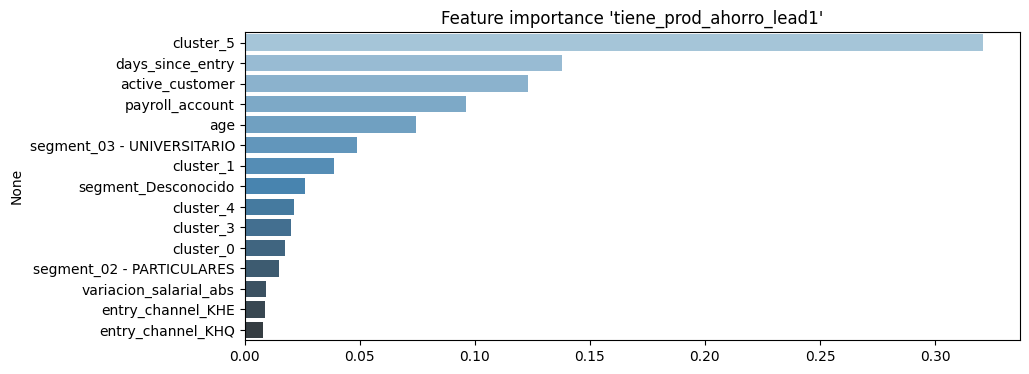

Identificamos y graficamos las 15 características más importantes según su contribución al modelo, ordenadas de mayor a menor.


In [184]:
# Definimos los parámetros para el RandomForestClassifier
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

# Separamos las características (X) y la variable objetivo (y)
x, y = df_train_ahorro.drop(target_prod_ahorro, axis=1), df_train_ahorro[target_prod_ahorro]

# Entrenamos un RandomForestClassifier con los parámetros definidos
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)

# Obtenemos las 15 características más importantes
num_features = 15
features = clf.feature_importances_
columnas = x.columns

# Creamos una serie de pandas con las características y su importancia, ordenadas de mayor a menor
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)[:num_features]

# Creamos el gráfico
plt.figure(figsize=(10, 4))
plt.title("Feature importance '{}'".format(target_prod_ahorro))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

# Mostramos el gráfico
plt.show()

print("Identificamos y graficamos las 15 características más importantes según su contribución al modelo, ordenadas de mayor a menor.")

In [185]:
df_train_ahorro

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,days_since_entry,em_acount,emc_account,entry_channel_KAT,entry_channel_KFC,entry_channel_KHE,entry_channel_KHQ,entry_channel_Otros,gender_V,payroll_account,region_name_Albacete,region_name_Alicante/Alacant,region_name_Asturias,region_name_Badajoz,"region_name_Balears, Illes",region_name_Barcelona,region_name_Cantabria,region_name_Castellón/Castelló,"region_name_Coruña, A",region_name_Cáceres,region_name_Cádiz,region_name_Córdoba,region_name_Granada,region_name_Huelva,region_name_Madrid,region_name_Murcia,region_name_Málaga,region_name_Otros,"region_name_Palmas, Las",region_name_Pontevedra,region_name_Salamanca,region_name_Sevilla,region_name_Toledo,region_name_Valencia/València,region_name_Valladolid,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,tiene_prod_ahorro_lead1,variacion_salarial_abs
0,1,53,0,0,0,0,0,1,0,407,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,102405.750000,0.0,0,1,0,0,1.0,0.000000
1,0,81,1,0,0,0,0,0,0,1076,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80161.620000,0.0,0,1,0,0,1.0,0.000000
2,1,64,1,0,0,0,0,0,0,23,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,112952.168691,0.0,0,0,0,1,1.0,0.000000
3,1,50,0,0,0,0,1,0,0,6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,138618.570000,0.0,0,1,0,0,1.0,0.000000
4,1,62,1,0,0,0,0,0,0,29,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,125530.410000,0.0,1,0,0,0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61395,0,30,0,0,0,1,0,0,0,1298,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,82381.500000,0.0,0,0,1,0,0.0,0.000000
166161,0,32,0,1,0,0,0,0,0,879,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93168.810000,0.0,0,0,1,0,0.0,0.000000
165733,0,22,1,0,0,0,0,0,0,729,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,99855.540000,0.0,0,0,1,0,0.0,0.000000
334460,0,29,0,1,0,0,0,0,0,115,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74029.074283,0.0,0,1,0,0,0.0,14925.271342


In [186]:
# Identificamos columnas numéricas con mayoría de valores 1
# Creamos una lista vacía para almacenar los nombres de las columnas que cumplen con la condición
columnas_mayoria_unos = []

# Iteramos sobre cada columna del dataframe de entrenamiento
for col in df_train_ahorro.columns:
    if df_train_ahorro[col].dtype.kind in ['i', 'f']:
        valores_unicos = df_train_ahorro[col].unique()
        if set(valores_unicos).issubset({0, 1}):
            proporcion_unos = df_train_ahorro[col].mean()
            if proporcion_unos > 0.70:
                columnas_mayoria_unos.append(col)
                print(f"Columna: {col}, Proporción de 1s: {proporcion_unos}")

# Imprimimos las columnas que tienen una mayoría de 1s
print('Columnas con mayoría de 1s:', columnas_mayoria_unos)

Columnas con mayoría de 1s: []


### 2.2 Split X-y

In [187]:
# Se guarda la target como 'y' y las features como 'X'
# La variable 'y' contendrá la columna objetivo que queremos predecir
# La variable 'X' contendrá todas las columnas excepto la columna objetivo

# Asignamos la columna objetivo (target) a la variable 'y'
y = df_train_ahorro[target_prod_ahorro]

# Asignamos las características (features) a la variable 'X'
# Eliminamos la columna objetivo del dataframe de entrenamiento
X = df_train_ahorro.drop(target_prod_ahorro, axis=1)

# Imprimimos un mensaje indicando que hemos guardado la target como 'y' y las features como 'X'
print("Guardamos la target como 'y' y las features como 'X'")

Guardamos la target como 'y' y las features como 'X'


### 2.3 Rescaling

In [188]:
X

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,days_since_entry,em_acount,emc_account,entry_channel_KAT,entry_channel_KFC,entry_channel_KHE,entry_channel_KHQ,entry_channel_Otros,gender_V,payroll_account,region_name_Albacete,region_name_Alicante/Alacant,region_name_Asturias,region_name_Badajoz,"region_name_Balears, Illes",region_name_Barcelona,region_name_Cantabria,region_name_Castellón/Castelló,"region_name_Coruña, A",region_name_Cáceres,region_name_Cádiz,region_name_Córdoba,region_name_Granada,region_name_Huelva,region_name_Madrid,region_name_Murcia,region_name_Málaga,region_name_Otros,"region_name_Palmas, Las",region_name_Pontevedra,region_name_Salamanca,region_name_Sevilla,region_name_Toledo,region_name_Valencia/València,region_name_Valladolid,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,variacion_salarial_abs
0,1,53,0,0,0,0,0,1,0,407,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,102405.750000,0.0,0,1,0,0,0.000000
1,0,81,1,0,0,0,0,0,0,1076,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80161.620000,0.0,0,1,0,0,0.000000
2,1,64,1,0,0,0,0,0,0,23,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,112952.168691,0.0,0,0,0,1,0.000000
3,1,50,0,0,0,0,1,0,0,6,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,138618.570000,0.0,0,1,0,0,0.000000
4,1,62,1,0,0,0,0,0,0,29,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,125530.410000,0.0,1,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61395,0,30,0,0,0,1,0,0,0,1298,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,82381.500000,0.0,0,0,1,0,0.000000
166161,0,32,0,1,0,0,0,0,0,879,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,93168.810000,0.0,0,0,1,0,0.000000
165733,0,22,1,0,0,0,0,0,0,729,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,99855.540000,0.0,0,0,1,0,0.000000
334460,0,29,0,1,0,0,0,0,0,115,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,74029.074283,0.0,0,1,0,0,14925.271342


In [189]:
df_pred_ahorro

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,days_since_entry,em_acount,emc_account,entry_channel_KAT,entry_channel_KFC,entry_channel_KHE,entry_channel_KHQ,entry_channel_Otros,gender_V,payroll_account,region_name_Albacete,region_name_Alicante/Alacant,region_name_Asturias,region_name_Badajoz,"region_name_Balears, Illes",region_name_Barcelona,region_name_Cantabria,region_name_Castellón/Castelló,"region_name_Coruña, A",region_name_Cáceres,region_name_Cádiz,region_name_Córdoba,region_name_Granada,region_name_Huelva,region_name_Madrid,region_name_Murcia,region_name_Málaga,region_name_Otros,"region_name_Palmas, Las",region_name_Pontevedra,region_name_Salamanca,region_name_Sevilla,region_name_Toledo,region_name_Valencia/València,region_name_Valladolid,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,variacion_salarial_abs
0,0,62,1,0,0,0,0,0,0,190,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,160980.198311,0.0,0,1,0,0,19766.346572
1,1,70,1,0,0,0,0,0,0,156,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152841.136667,0.0,1,0,0,0,-101780.208333
2,1,58,1,0,0,0,0,0,0,240,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,180256.629898,0.0,0,1,0,0,45690.165071
3,1,55,1,0,0,0,0,0,0,891,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,407281.110000,0.0,0,1,0,0,0.000000
4,1,47,0,0,0,0,1,0,0,509,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,84511.860000,0.0,0,1,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416277,0,52,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52673.925000,0.0,0,0,0,1,0.000000
416278,0,30,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,113105.705172,0.0,0,0,0,1,0.000000
416279,0,21,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,170286.024236,0.0,0,0,0,1,0.000000
416280,0,43,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,355549.267500,0.0,0,0,0,1,0.000000


In [190]:
# Asignamos los nombres de las columnas de 'X' a la variable 'variables_entrenadas_ahorro'
variables_entrenadas_ahorro = X.columns

# Mostramos los nombres de las columnas que se han guardado en 'variables_entrenadas_ahorro'
variables_entrenadas_ahorro

Index(['active_customer', 'age', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'credit_card',
       'days_since_entry', 'em_acount', 'emc_account', 'entry_channel_KAT',
       'entry_channel_KFC', 'entry_channel_KHE', 'entry_channel_KHQ',
       'entry_channel_Otros', 'gender_V', 'payroll_account',
       'region_name_Albacete', 'region_name_Alicante/Alacant',
       'region_name_Asturias', 'region_name_Badajoz',
       'region_name_Balears, Illes', 'region_name_Barcelona',
       'region_name_Cantabria', 'region_name_Castellón/Castelló',
       'region_name_Coruña, A', 'region_name_Cáceres', 'region_name_Cádiz',
       'region_name_Córdoba', 'region_name_Granada', 'region_name_Huelva',
       'region_name_Madrid', 'region_name_Murcia', 'region_name_Málaga',
       'region_name_Otros', 'region_name_Palmas, Las',
       'region_name_Pontevedra', 'region_name_Salamanca',
       'region_name_Sevilla', 'region_name_Toledo',
       'region_name_Valenc

In [191]:
# Creamos una instancia de StandardScaler, que se utilizará para estandarizar las características
scaler = StandardScaler()

# Ajustamos el scaler a los datos de entrenamiento y transformamos las características
# Esto estandariza las características de X (media = 0, desviación estándar = 1)
X = scaler.fit_transform(X)

# Utilizamos el mismo scaler para transformar el conjunto de predicción
# Esto asegura que las características del conjunto de predicción se estandaricen de la misma manera que las del conjunto de entrenamiento
df_pred_ahorro = scaler.transform(df_pred_ahorro)

### 2.4 Split TRAIN-TEST

In [192]:
# Se utilizan 70% de los datos para entrenar el modelo y se guardan 30% de los datos para evaluar el modelo (de forma aleatoria)
# La función train_test_split divide los datos en conjuntos de entrenamiento y prueba.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [193]:
print('El nº observaciones del df de train es de:', len(y_train))
print('El nº observaciones del df de test es de:', len(y_test))

El nº observaciones del df de train es de: 101339
El nº observaciones del df de test es de: 43431


In [194]:
# Convertimos el conjunto de prueba (X_test) en un DataFrame
# Asignamos los nombres de las columnas originales utilizando la lista 'variables_entrenadas_ahorro'
# Esto es útil para mantener la interpretabilidad de los datos después de la estandarización

# Creamos un DataFrame a partir del conjunto de prueba (X_test)
df_X_test = pd.DataFrame(X_test, columns=variables_entrenadas_ahorro)

# Mostramos el DataFrame resultante
df_X_test

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,credit_card,days_since_entry,em_acount,emc_account,entry_channel_KAT,entry_channel_KFC,entry_channel_KHE,entry_channel_KHQ,entry_channel_Otros,gender_V,payroll_account,region_name_Albacete,region_name_Alicante/Alacant,region_name_Asturias,region_name_Badajoz,"region_name_Balears, Illes",region_name_Barcelona,region_name_Cantabria,region_name_Castellón/Castelló,"region_name_Coruña, A",region_name_Cáceres,region_name_Cádiz,region_name_Córdoba,region_name_Granada,region_name_Huelva,region_name_Madrid,region_name_Murcia,region_name_Málaga,region_name_Otros,"region_name_Palmas, Las",region_name_Pontevedra,region_name_Salamanca,region_name_Sevilla,region_name_Toledo,region_name_Valencia/València,region_name_Valladolid,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,variacion_salarial_abs
0,-0.937281,-0.033170,-0.432682,-0.477579,-0.325163,-0.552671,-0.396971,2.059028,-0.116483,-1.139189,-1.493715,-0.250205,-0.271665,-0.425028,-0.856411,-0.408623,1.927558,-0.991129,-0.275762,-0.103896,-0.180218,-0.146996,-0.131368,-0.108486,-0.330383,-0.113305,-0.106944,-0.195758,-0.110745,-0.161884,-0.110745,-0.130331,-0.103043,1.819423,-0.218384,-0.177068,-0.383989,-0.147192,-0.164671,-0.120411,-0.221713,-0.130522,-0.252194,-0.13731,-0.148582,-0.128179,-0.030367,-0.132155,1.307159,-1.179472,-0.181399,-0.046172
1,-0.937281,-0.668653,-0.432682,-0.477579,-0.325163,1.809394,-0.396971,-0.485666,-0.116483,0.234223,0.669472,-0.250205,-0.271665,2.352785,-0.856411,-0.408623,-0.518791,-0.991129,-0.275762,-0.103896,-0.180218,-0.146996,-0.131368,-0.108486,-0.330383,-0.113305,-0.106944,-0.195758,-0.110745,-0.161884,-0.110745,-0.130331,-0.103043,1.819423,-0.218384,-0.177068,-0.383989,-0.147192,-0.164671,-0.120411,-0.221713,-0.130522,-0.252194,-0.13731,-0.148582,0.143044,-0.030367,-0.132155,-0.765018,0.847837,-0.181399,-0.046172
2,-0.937281,1.396669,-0.432682,2.093893,-0.325163,-0.552671,-0.396971,-0.485666,-0.116483,-1.136900,-1.493715,-0.250205,-0.271665,-0.425028,-0.856411,2.447242,-0.518791,-0.991129,-0.275762,-0.103896,-0.180218,-0.146996,-0.131368,-0.108486,-0.330383,-0.113305,-0.106944,-0.195758,-0.110745,-0.161884,-0.110745,-0.130331,-0.103043,1.819423,-0.218384,-0.177068,-0.383989,-0.147192,-0.164671,-0.120411,-0.221713,-0.130522,-0.252194,-0.13731,-0.148582,0.227897,-0.030367,-0.132155,1.307159,-1.179472,-0.181399,0.466111
3,1.066916,-0.906960,2.311168,-0.477579,-0.325163,-0.552671,-0.396971,-0.485666,-0.116483,-1.008715,0.669472,-0.250205,-0.271665,-0.425028,-0.856411,2.447242,-0.518791,-0.991129,-0.275762,-0.103896,5.548841,-0.146996,-0.131368,-0.108486,-0.330383,-0.113305,-0.106944,-0.195758,-0.110745,-0.161884,-0.110745,-0.130331,-0.103043,-0.549625,-0.218384,-0.177068,-0.383989,-0.147192,-0.164671,-0.120411,-0.221713,-0.130522,-0.252194,-0.13731,-0.148582,-0.211424,-0.030367,-0.132155,-0.765018,0.847837,-0.181399,-0.196343
4,1.066916,3.064813,2.311168,-0.477579,-0.325163,-0.552671,-0.396971,-0.485666,-0.116483,-1.466519,0.669472,-0.250205,-0.271665,-0.425028,1.167663,-0.408623,-0.518791,-0.991129,-0.275762,-0.103896,-0.180218,-0.146996,-0.131368,-0.108486,3.026787,-0.113305,-0.106944,-0.195758,-0.110745,-0.161884,-0.110745,-0.130331,-0.103043,-0.549625,-0.218384,-0.177068,-0.383989,-0.147192,-0.164671,-0.120411,-0.221713,-0.130522,-0.252194,-0.13731,-0.148582,1.006805,-0.030367,-0.132155,-0.765018,-1.179472,5.512699,-0.046172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43426,-0.937281,0.522879,-0.432682,-0.477579,-0.325163,1.809394,-0.396971,-0.485666,-0.116483,0.080859,0.669472,-0.250205,3.680998,-0.425028,-0.856411,-0.408623,-0.518791,-0.991129,-0.275762,-0.103896,-0.180218,6.802908,-0.131368,-0.108486,-0.330383,-

### 2.5 Torneo de modelos

In [195]:
# Definimos una lista vacía para almacenar los modelos
modelos = []

# Añadimos los siguientes modelos a la lista de modelos:
modelos.append(('Perceptron', Perceptron(random_state=42)))
modelos.append(('SGDClassifier', SGDClassifier(loss='log_loss', random_state=42)))
modelos.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)))
modelos.append(('XGBClassifier', XGBClassifier(random_state=42, verbosity=0)))
modelos.append(('CatBoostClassifier', CatBoostClassifier(verbose=False, random_seed=42)))
modelos.append(('LogisticRegression', LogisticRegression(random_state=42)))

In [196]:
# Creamos un DataFrame vacío para almacenar las métricas de los modelos
metricas_modelos = pd.DataFrame(columns=['modelo', 'AUC'])

# Iteramos sobre la lista de modelos y entrenamos cada modelo
for nombre, modelo in modelos:

  # Entrenamos el modelo con los datos de entrenamiento
  modelo.fit(X_train, y_train)

  # Hacemos la predicción sobre el dataset de test
  # El AUC se calcula con predict_proba.
  # Para el Perceptron, usaremos decision_function, el equivalente de predict_proba para este algoritmo
  if nombre == 'Perceptron':
    y_pred = modelo.decision_function(X_test)
  else:
    y_pred = modelo.predict_proba(X_test)[:, 1]

  # Calculamos el AUC (Area Under the Curve) para evaluar el rendimiento del modelo
  auc = metrics.roc_auc_score(y_test, y_pred)

  # Imprimimos el resultado por modelo
  metricas_modelos = pd.concat([metricas_modelos,
                  pd.DataFrame({'modelo': nombre, 'AUC': auc}, index=[0])
                  ])
  print(modelo, auc)

# Ordenamos los modelos por AUC de forma descendente
metricas_modelos.sort_values('AUC', ascending=False)

Perceptron(random_state=42) 0.8786157177797242
SGDClassifier(loss='log_loss', random_state=42) 0.9361797888887873
GradientBoostingClassifier(random_state=42) 0.9592450686187206
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...) 0.9648999855625686
<catboost.core.CatBoostClassifier object at 0x00

,modelo,AUC
0,CatBoostClassifier,0.965387
0,XGBClassifier,0.964900
0,GradientBoostingClassifier,0.959245
0,LogisticRegression,0.938461
0,SGDClassifier,0.936180
0,Perceptron,0.878616


In [197]:
# Ordenamos los modelos por AUC de forma descendente
# Esto nos permite identificar el modelo con el mejor rendimiento (mayor AUC)
metricas_modelos = metricas_modelos.sort_values('AUC', ascending=False)

# Utilizamos iloc[0] para seleccionar la primera fila del DataFrame ordenado
modelo_ganador = metricas_modelos.iloc[0]

# Extraemos el nombre del modelo ganador
nombre_modelo_ganador = modelo_ganador['modelo']

# Extraemos el valor del AUC del modelo ganador
auc_modelo_ganador = modelo_ganador['AUC']

# Mostramos el nombre del modelo ganador y su AUC con tres decimales
print("El modelo ganador es {} con un AUC de {:.3f}".format(nombre_modelo_ganador, auc_modelo_ganador))

El modelo ganador es CatBoostClassifier con un AUC de 0.965


### 2.6. Modelado Final

In [198]:
# Selección del mejor modelo con los mejores parámetros, que son los estándar
modelo = CatBoostClassifier(verbose=False, random_state=42)

# Entrenamiento del modelo
modelo.fit(X_train, y_train)

print("Entrenamos el modelo con los parámetros estándar del modelo")

Entrenamos el modelo con los parámetros estándar del modelo


In [199]:
# Realizamos la predicción en el dataset de entrenamiento
y_pred_train = modelo.predict_proba(X_train)

# Evaluamos la métrica AUC en el dataset de entrenamiento
auc_train = metrics.roc_auc_score(y_train, y_pred_train[:, 1])

# Imprimimos el resultado del AUC sobre el dataset de entrenamiento
print("El AUC sobre el df_train es de: {:.5f}".format(auc_train))


El AUC sobre el df_train es de: 0.97519


In [200]:
# Realizamos la predicción en el dataset de test
y_pred_test = modelo.predict_proba(X_test)

# Evaluamos la métrica AUC en el dataset de test
auc_test = metrics.roc_auc_score(y_test, y_pred_test[:, 1])

# Imprimimos el resultado del AUC sobre el dataset de test
print("El AUC sobre el df_test es de: {:.5f}".format(auc_test))

El AUC sobre el df_test es de: 0.96539


In [201]:
# Importamos la función mutual_info_classif para la selección de características
# Esta función calcula la información mutua entre cada característica y la variable objetivo
from sklearn.feature_selection import mutual_info_classif

# Calculamos la información mutua entre las características (X_train) y la variable objetivo (y_train)
# La información mutua mide la dependencia entre las variables, es decir, cuánta información sobre la variable objetivo
mutual_info = mutual_info_classif(X_train, y_train)

# Imprimimos los valores de información mutua para cada característica
print(mutual_info)

[0.10280333 0.05344546 0.00845608 0.0472488  0.0085381  0.051066
 0.01236081 0.15316438 0.00738328 0.14621365 0.00728877 0.01334003
 0.00902481 0.01357228 0.02379739 0.02750001 0.02012994 0.00878085
 0.04929558 0.00119708 0.00330035 0.00533192 0.00244922 0.00046064
 0.00545729 0.00423248 0.00084037 0.00388274 0.00024683 0.00302573
 0.00138278 0.00340698 0.         0.01362001 0.00356378 0.00289217
 0.00440003 0.00120325 0.00133593 0.00078306 0.00348544 0.00293552
 0.00566709 0.         0.00205328 0.01718543 0.00240043 0.00909432
 0.02709888 0.05179707 0.01623148 0.02558043]


In [202]:
# Importamos la función cross_val_score para realizar validación cruzada
from sklearn.model_selection import cross_val_score

# Calculamos las puntuaciones AUC utilizando validación cruzada con 5 particiones
# cross_val_score entrena y evalúa el modelo en diferentes particiones de los datos
auc_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='roc_auc')

# Imprimimos la media de las puntuaciones AUC obtenidas
# Esto nos da una idea del rendimiento promedio del modelo en diferentes particiones de los datos
print(auc_scores.mean())

0.9648043077659347


AUC scores for each fold: [0.9115118  0.92312768 0.93087372 0.93339009 0.84434644]
Mean AUC: 0.9086499455458691


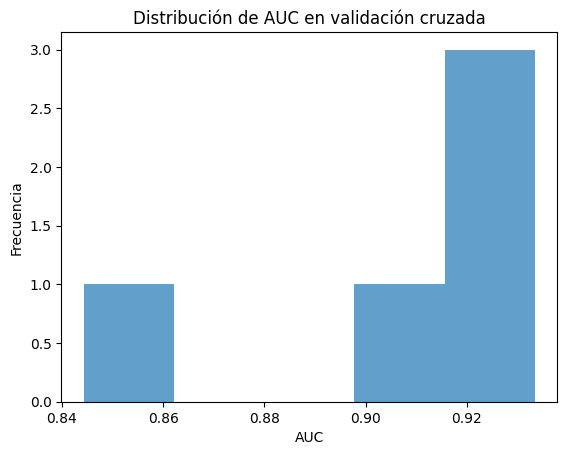

In [203]:
# Realizamos la validación cruzada utilizando la métrica AUC
# cross_val_score entrena y evalúa el modelo en diferentes particiones de los datos

auc_scores = cross_val_score(clf, x, y, cv=5, scoring='roc_auc')

# Imprimimos los AUC scores obtenidos en cada partición (fold)
print("AUC scores for each fold:", auc_scores)

# Calculamos e imprimimos la media de los AUC scores
print("Mean AUC:", auc_scores.mean())

# Visualizamos la distribución de los AUC scores utilizando un histograma

plt.hist(auc_scores, bins=5, alpha=0.7)
plt.title("Distribución de AUC en validación cruzada")
plt.xlabel("AUC")
plt.ylabel("Frecuencia")
plt.show()


### 2.7 INTERPRETABILITY

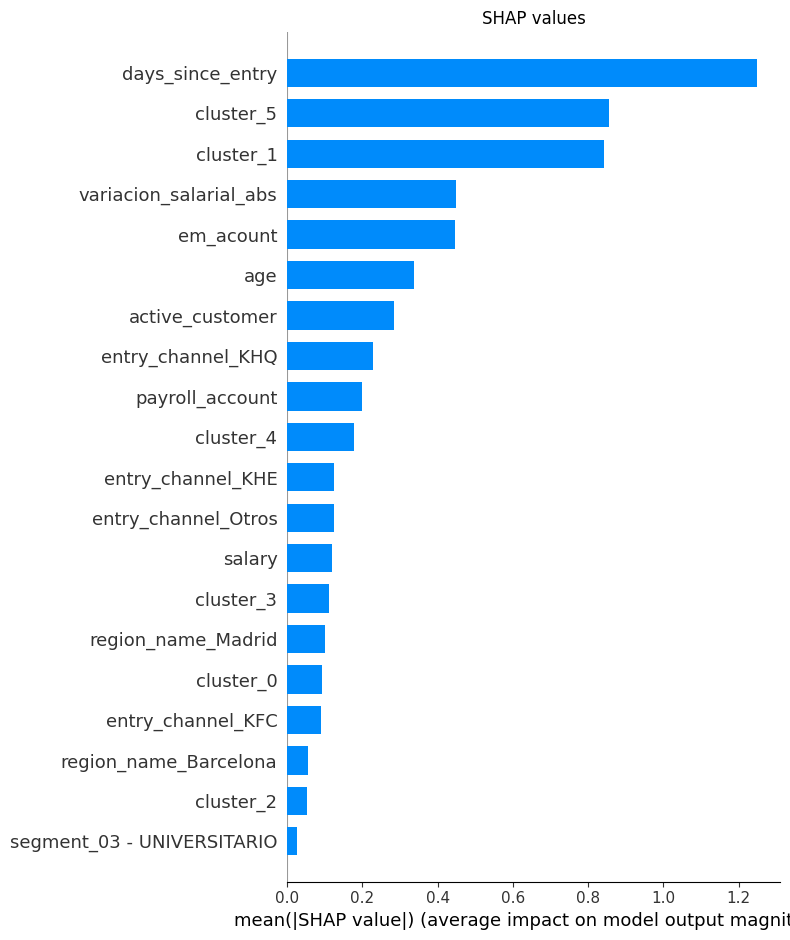

Las 5 features más importantes según los valores SHAP son:
days_since_entry: 1.2476
cluster_5: 0.8559
cluster_1: 0.8424
variacion_salarial_abs: 0.4492
em_acount: 0.4451


In [204]:
# Se crea un objeto explainer utilizando TreeExplainer de SHAP para el modelo entrenado
explainer = shap.TreeExplainer(modelo)

# Se calculan los valores SHAP para el conjunto de prueba (df_X_test)
shap_values = explainer.shap_values(df_X_test)

# Se establece el título del gráfico
plt.title('SHAP values')

# Se genera un gráfico de resumen de los valores SHAP en forma de barra, mostrando las 20 características más importantes
shap.summary_plot(shap_values, df_X_test, plot_type="bar", max_display=20)

# Se calcula la importancia promedio de cada característica en términos absolutos
importancia_shap = pd.DataFrame({
    'feature': df_X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

# Se seleccionan las 5 características más importantes
top_features = importancia_shap.head(5)

# Se imprimen las 5 características principales junto con su importancia
print("Las 5 features más importantes según los valores SHAP son:")
for i, row in top_features.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

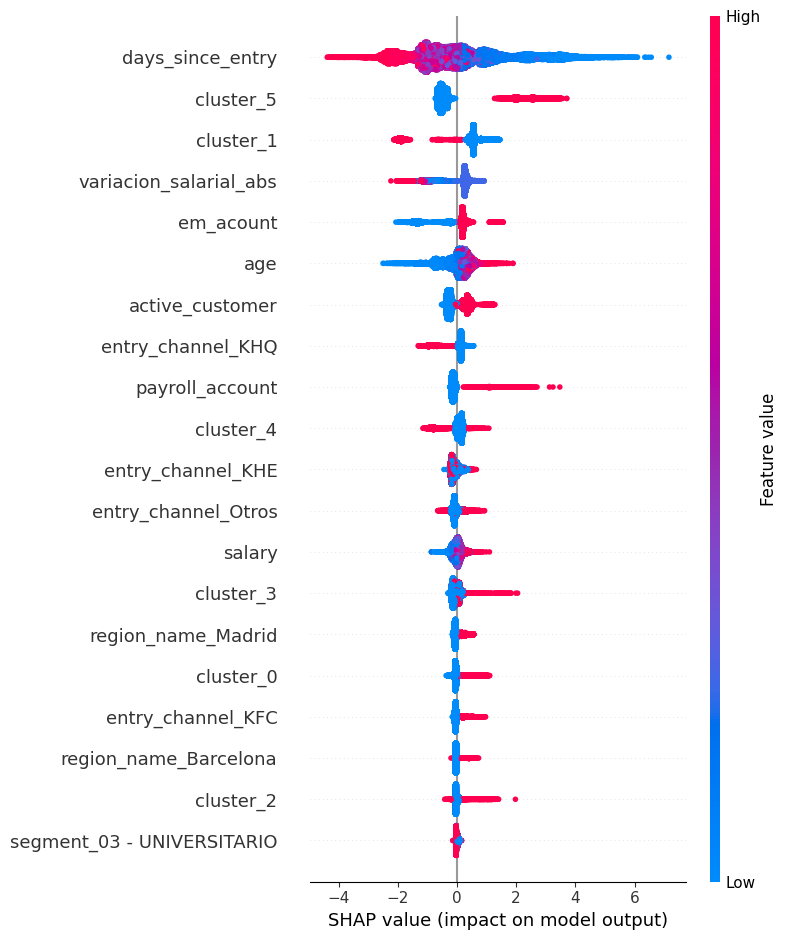

In [205]:
# Generamos el gráfico de resumen de los valores SHAP
shap.summary_plot(shap_values, df_X_test)

### 2.8. Matriz de confusion 

In [206]:
# Convertimos las predicciones del conjunto de test en un DataFrame
y_pred_test2 = pd.DataFrame(y_pred_test)

# Seleccionamos la segunda columna que contiene las probabilidades de la clase positiva
y_pred_test2 = y_pred_test2[1]

# Mostramos las probabilidades de la clase positiva
y_pred_test2

0        0.815982
1        0.106676
2        0.000574
3        0.009848
4        0.919270
           ...   
43426    0.063944
43427    0.008765
43428    0.079970
43429    0.011745
43430    0.002450
Name: 1, Length: 43431, dtype: float64

In [207]:
# Convertimos las probabilidades de predicción en etiquetas binarias (0 o 1)
# Si la probabilidad es mayor o igual a 0.5, se asigna 1, de lo contrario se asigna 0
y_pred_test2 = (y_pred_test2 >= 0.5).astype(int)

# Mostramos las etiquetas binarias resultantes
y_pred_test2

0        1
1        0
2        0
3        0
4        1
        ..
43426    0
43427    0
43428    0
43429    0
43430    0
Name: 1, Length: 43431, dtype: int32

In [208]:
# Imprimimos las primeras 5 observaciones de y_test
print("y_test:", y_test[:5])

# Imprimimos las primeras 5 predicciones de y_pred_test2
print("y_pred_test:", y_pred_test2[:5])

y_test: 301231    0.0
196547    0.0
406471    0.0
368939    0.0
28924     1.0
Name: tiene_prod_ahorro_lead1, dtype: float64
y_pred_test: 0    1
1    0
2    0
3    0
4    1
Name: 1, dtype: int32


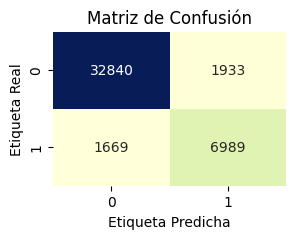

In [209]:
# Creamos la matriz de confusión utilizando las etiquetas reales (y_test) y las etiquetas predichas (y_pred_test2)
cm = metrics.confusion_matrix(y_test, y_pred_test2)

# Configuramos el tamaño de la figura para el gráfico de la matriz de confusión
plt.figure(figsize=(3, 2))

# Generamos un mapa de calor (heatmap) para visualizar la matriz de confusión

sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)

# Creamos el gráfico
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')

# Mostramos el gráfico
plt.show()

### 2.9. Curva ROC

In [210]:
# Convertimos las predicciones del conjunto de entrenamiento en un DataFrame
y_pred_train2 = pd.DataFrame(y_pred_train)

# Seleccionamos la segunda columna que contiene las probabilidades de la clase positiva
y_pred_train2 = y_pred_train2[1]

# Mostramos las probabilidades de la clase positiva
y_pred_train2

0         0.181241
1         0.008740
2         0.198994
3         0.177517
4         0.588844
            ...   
101334    0.001133
101335    0.002454
101336    0.002641
101337    0.016384
101338    0.311686
Name: 1, Length: 101339, dtype: float64

In [211]:
# Convertimos las probabilidades de predicción en etiquetas binarias (0 o 1)
# Si la probabilidad es mayor o igual a 0.5, se asigna 1, de lo contrario se asigna 0
y_pred_train2 = (y_pred_train2 >= 0.5).astype(int)

# Mostramos las etiquetas binarias resultantes
y_pred_train2

0         0
1         0
2         0
3         0
4         1
         ..
101334    0
101335    0
101336    0
101337    0
101338    0
Name: 1, Length: 101339, dtype: int32

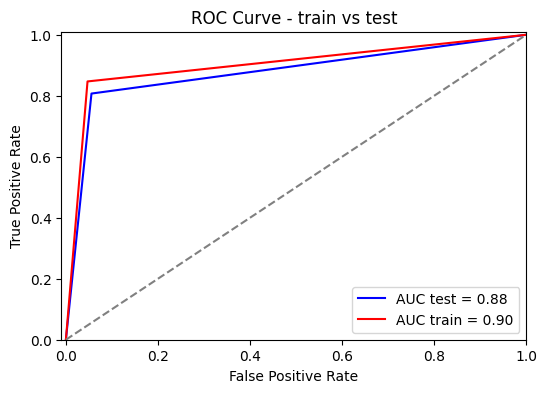

In [212]:
# Calculamos las métricas ROC para el conjunto de test
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test, y_pred_test2)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# Calculamos las métricas ROC para el conjunto de entrenamiento
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, y_pred_train2)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Configuramos el tamaño de la figura para el gráfico de la curva ROC
plt.figure(figsize=(6, 4))

# Graficamos la curva ROC para el conjunto de test
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC test = %0.2f' % roc_auc_test)

# Graficamos la curva ROC para el conjunto de entrenamiento
plt.plot(fpr_train, tpr_train, 'r', label = 'AUC train = %0.2f' % roc_auc_train)

# Creamos el gráfico
plt.title('ROC Curve - train vs test')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Mostramos el gráfico
plt.show()

### 2.10 Predict

In [213]:
# Creamos un array con las predicciones del modelo (en unos y ceros)
pred = modelo.predict(df_pred_ahorro)
pred_proba = modelo.predict_proba(df_pred_ahorro)
print(f' El resultado del la predicción esta en formato array', '\n',  pred_proba)

 El resultado del la predicción esta en formato array 
 [[0.92716445 0.07283555]
 [0.90982161 0.09017839]
 [0.98716683 0.01283317]
 ...
 [0.98920986 0.01079014]
 [0.85838822 0.14161178]
 [0.99284427 0.00715573]]


In [214]:
df_ids_predecir_ahorro 

,pk_cid,pk_partition
0,16063,2019-05-28
1,16203,2019-05-28
2,16502,2019-05-28
3,17590,2019-05-28
4,17799,2019-05-28
...,...,...
416277,1553685,2019-05-28
416278,1553686,2019-05-28
416279,1553687,2019-05-28
416280,1553688,2019-05-28


In [215]:
# Seleccionamos el ID del cliente del dataframe df_ids_predecir_ahorro
customer_id = df_ids_predecir_ahorro['pk_cid']

In [216]:
# Convertimos las probabilidades de predicción en un DataFrame
# Esto nos permite visualizar y manipular las probabilidades de predicción de manera más conveniente
pred_proba = pd.DataFrame(pred_proba)

# Mostramos el DataFrame resultante que contiene las probabilidades de predicción
pred_proba

,0,1
0,0.927164,0.072836
1,0.909822,0.090178
2,0.987167,0.012833
3,0.809649,0.190351
4,0.870159,0.129841
...,...,...
416277,0.972333,0.027667
416278,0.989827,0.010173
416279,0.989210,0.010790
416280,0.858388,0.141612


In [217]:
# Creamos un dataframe vacío para almacenar las predicciones y las probabilidades
df_prediccion_ahorro = pd.DataFrame()

# Asignamos el ID del cliente al dataframe
df_prediccion_ahorro['Customer_ID'] = customer_id

# Asignamos las predicciones al dataframe
df_prediccion_ahorro['prediccion'] = pred

# Asignamos las probabilidades de predicción al dataframe
df_prediccion_ahorro['%_proba'] = pred_proba[1]

# Imprimimos un mensaje indicando que podemos ver la predicción de cada cliente junto a la probabilidad de la predicción
print('Podemos ver la prediccion de cada cliente junto a la probabilidad de la prediccion')

# Mostramos el dataframe resultante
df_prediccion_ahorro



Podemos ver la prediccion de cada cliente junto a la probabilidad de la prediccion


,Customer_ID,prediccion,%_proba
0,16063,0.0,0.072836
1,16203,0.0,0.090178
2,16502,0.0,0.012833
3,17590,0.0,0.190351
4,17799,0.0,0.129841
...,...,...,...
416277,1553685,0.0,0.027667
416278,1553686,0.0,0.010173
416279,1553687,0.0,0.010790
416280,1553688,0.0,0.141612


In [218]:
# Filtramos el dataframe 'df_prediccion_ahorro' para quedarnos solo con las predicciones cuya probabilidad es mayor al 50%
# Esto significa que solo conservamos las filas donde la columna '%_proba' tiene un valor superior a 0.5
df_prediccion_ahorro = df_prediccion_ahorro[df_prediccion_ahorro['%_proba'] > 0.5]

### 2.11. Guarda predicciones

In [219]:
# Guardamos el dataframe de predicciones en un archivo CSV
df_prediccion_ahorro.to_csv('reports/predicciones_prod_cuenta.csv')

## 3. Modelo Productos Financieros

### DF Financieros

In [220]:
# Cargamos los datasets desde archivos pickle

df_train_finan = pd.read_pickle("pickle/df_train_finan.pkl")
df_pred_finan = pd.read_pickle("pickle/df_pred_finan.pkl")

In [221]:
# Reemplazamos valores negativos en la columna 'days_since_entry' por 0 en el dataframe de entrenamiento
df_train_finan['days_since_entry'] = df_train_finan['days_since_entry'].apply(lambda x: 0 if x < 0 else x)

# Reemplazamos valores negativos en la columna 'days_since_entry' por 0 en el dataframe de predicción
df_pred_finan['days_since_entry'] = df_pred_finan['days_since_entry'].apply(lambda x: 0 if x < 0 else x)

In [222]:
# Definimos la variable objetivo (target) para el modelo de productos financieros

target_prod_finan = 'tiene_prod_finan_lead1'

In [223]:
# Eliminamos la columna 'tiene_prod_finan_lead1' del dataframe de predicción
# No debe estar presente en el dataframe de predicción ya que es la variable que intentamos predecir
del(df_pred_finan[target_prod_finan])

# Eliminamos la columna 'total_sin_tiene_prod_financiacion' del dataframe de entrenamiento
# Esta columna no es necesaria para el modelo y se elimina para evitar cualquier posible sesgo o redundancia en los datos
del(df_train_finan['total_sin_tiene_prod_financiacion'])

# Eliminamos la columna 'total_sin_tiene_prod_financiacion' del dataframe de predicción
# Al igual que en el dataframe de entrenamiento, eliminamos esta columna para mantener la consistencia en los datos de predicción
del(df_pred_finan['total_sin_tiene_prod_financiacion'])

### 3.1 Features Importance

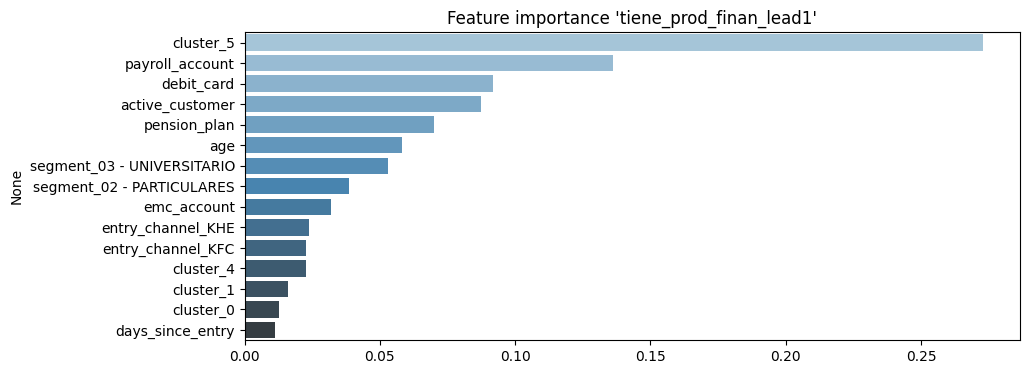

Identificamos y graficamos las 15 características más importantes según su contribución al modelo, ordenadas de mayor a menor.


In [224]:
# Definimos los parámetros para el RandomForestClassifier
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

# Separamos las características (X) y la variable objetivo (y)
x, y = df_train_finan.drop(target_prod_finan, axis=1), df_train_finan[target_prod_finan]

# Entrenamos un RandomForestClassifier con los parámetros definidos
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)

# Obtenemos las 15 características más importantes
num_features = 15
features = clf.feature_importances_
columnas = x.columns

# Creamos una serie de pandas con las características y su importancia, ordenadas de mayor a menor
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)[:num_features]

# Creamos el gráfico
plt.figure(figsize=(10, 4))
plt.title("Feature importance '{}'".format(target_prod_finan))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

# Mostramos el gráfico
plt.show()

print("Identificamos y graficamos las 15 características más importantes según su contribución al modelo, ordenadas de mayor a menor.")

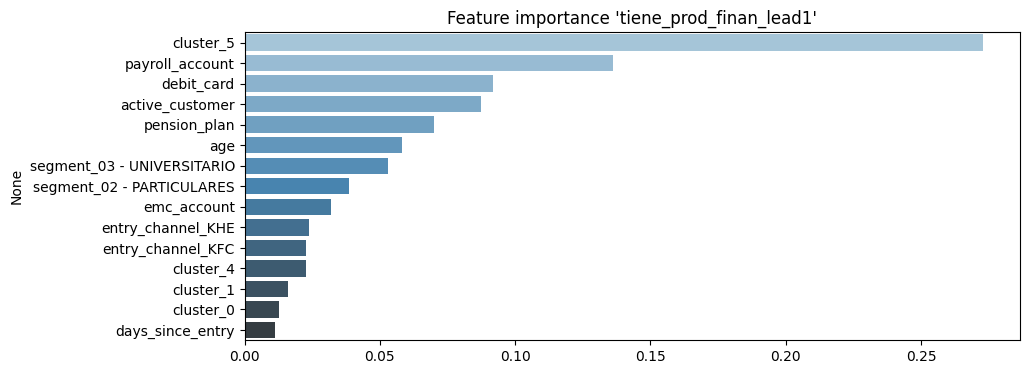

Identificamos y graficamos las 15 características más importantes según su contribución al modelo, ordenadas de mayor a menor.


In [225]:
# Definimos los parámetros para el RandomForestClassifier
params = {'random_state': 42, 'n_jobs': 4, 'n_estimators': 100, 'max_depth': 4}

# Separamos las características (X) y la variable objetivo (y)
x, y = df_train_finan.drop(target_prod_finan, axis=1), df_train_finan[target_prod_finan]

# Entrenamos un RandomForestClassifier con los parámetros definidos
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)

# Obtenemos las 15 características más importantes
num_features = 15
features = clf.feature_importances_
columnas = x.columns

# Creamos una serie de pandas con las características y su importancia, ordenadas de mayor a menor
imp = pd.Series(data=features, index=columnas).sort_values(ascending=False)[:num_features]

# Creamos el gráfico
plt.figure(figsize=(10, 4))
plt.title("Feature importance '{}'".format(target_prod_finan))
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

# Mostramos el gráfico
plt.show()

print("Identificamos y graficamos las 15 características más importantes según su contribución al modelo, ordenadas de mayor a menor.")

### 3.2 Split X-y

In [226]:
# Asignamos la columna objetivo (target) a la variable 'y'
y = df_train_finan[target_prod_finan]

# Eliminamos la columna objetivo del dataframe de entrenamiento
X = df_train_finan.drop(target_prod_finan, axis=1)

# Imprimimos un mensaje indicando que hemos guardado la target como 'y' y las features como 'X'
print("Guardamos la target como 'y' y las features como 'X'")

Guardamos la target como 'y' y las features como 'X'


### 3.3 Rescaling

In [227]:
# Guardamos los nombres de las columnas del dataset original en una lista
# Esto es necesario porque el método scaler eliminará los nombres de las variables durante la estandarización
# Para mantener la interpretabilidad, especialmente si el modelo ganador es un árbol de decisión, es útil conservar los nombres de las variables
variables_entrenadas_finan = X.columns

# Mostramos los nombres de las columnas que se han guardado en 'variables_entrenadas_finan'
variables_entrenadas_finan

Index(['active_customer', 'age', 'cluster_0', 'cluster_1', 'cluster_2',
       'cluster_3', 'cluster_4', 'cluster_5', 'days_since_entry', 'debit_card',
       'em_acount', 'emc_account', 'entry_channel_KAT', 'entry_channel_KFC',
       'entry_channel_KHE', 'entry_channel_KHQ', 'entry_channel_Otros',
       'gender_V', 'long_term_deposit', 'payroll_account', 'pension_plan',
       'region_name_Alicante/Alacant', 'region_name_Asturias',
       'region_name_Badajoz', 'region_name_Balears, Illes',
       'region_name_Barcelona', 'region_name_Cantabria',
       'region_name_Castellón/Castelló', 'region_name_Coruña, A',
       'region_name_Cáceres', 'region_name_Cádiz', 'region_name_Córdoba',
       'region_name_Granada', 'region_name_Huelva', 'region_name_Madrid',
       'region_name_Murcia', 'region_name_Málaga', 'region_name_Otros',
       'region_name_Palmas, Las', 'region_name_Pontevedra',
       'region_name_Salamanca', 'region_name_Sevilla', 'region_name_Toledo',
       'region_name_V

In [228]:
# Creamos una instancia de StandardScaler para estandarizar las características
scaler = StandardScaler()

# Ajustamos el scaler a los datos de entrenamiento y transformamos las características
# Esto estandariza las características de X (media = 0, desviación estándar = 1)
X = scaler.fit_transform(X)

# Utilizamos el mismo scaler para transformar el conjunto de predicción
# Esto asegura que las características del conjunto de predicción se estandaricen de la misma manera que las del conjunto de entrenamiento
df_pred_finan = scaler.transform(df_pred_finan)

### 3.4 Split TRAIN-TEST

In [229]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
# Utilizamos el 70% de los datos para entrenar el modelo y el 30% restante para evaluar el modelo
# La división se realiza de forma aleatoria, pero se utiliza una semilla (random_state=42) para asegurar la reproducibilidad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [230]:
print('El nº observaciones del df de train es de:', len(y_train))
print('El nº observaciones del df de test es de:', len(y_test))

El nº observaciones del df de train es de: 22963
El nº observaciones del df de test es de: 9842


In [231]:
# Convertimos el conjunto de prueba (X_test) en un DataFrame
# Asignamos los nombres de las columnas originales utilizando la lista 'variables_entrenadas_finan'
# Esto es útil para mantener la interpretabilidad de los datos después de la estandarización
df_X_test = pd.DataFrame(X_test, columns=variables_entrenadas_finan)

# Mostramos el DataFrame resultante
df_X_test

,active_customer,age,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,days_since_entry,debit_card,em_acount,emc_account,entry_channel_KAT,entry_channel_KFC,entry_channel_KHE,entry_channel_KHQ,entry_channel_Otros,gender_V,long_term_deposit,payroll_account,pension_plan,region_name_Alicante/Alacant,region_name_Asturias,region_name_Badajoz,"region_name_Balears, Illes",region_name_Barcelona,region_name_Cantabria,region_name_Castellón/Castelló,"region_name_Coruña, A",region_name_Cáceres,region_name_Cádiz,region_name_Córdoba,region_name_Granada,region_name_Huelva,region_name_Madrid,region_name_Murcia,region_name_Málaga,region_name_Otros,"region_name_Palmas, Las",region_name_Pontevedra,region_name_Salamanca,region_name_Sevilla,region_name_Toledo,region_name_Valencia/València,region_name_Valladolid,region_name_Zaragoza,salary,salary_increase_pct,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,segment_Desconocido,variacion_salarial_abs
0,1.006453,-0.499414,-0.399958,-0.466105,-0.313991,-0.542200,2.522953,-0.547940,0.475632,-0.474900,0.752940,-0.343876,-0.310463,-0.495948,1.279558,-0.399239,-0.496902,0.975636,-0.170527,-0.395846,-0.334602,-0.174277,-0.144614,-0.132143,-0.113331,-0.327573,-0.112778,-0.106951,5.090324,-0.109117,-0.155345,-0.110821,-0.125164,-0.102489,-0.5718,-0.210585,-0.168242,-0.384174,-0.14809,-0.163095,-0.118596,-0.217747,-0.130098,-0.257034,-0.136262,-0.147120,-0.336087,-0.03054,-0.165443,-0.828633,0.901794,-0.122372,-0.034115
1,1.006453,-0.967223,2.500265,-0.466105,-0.313991,-0.542200,-0.396361,-0.547940,-1.005107,-0.474900,0.752940,-0.343876,-0.310463,-0.495948,-0.781520,2.504763,-0.496902,-1.024973,-0.170527,-0.395846,-0.334602,-0.174277,-0.144614,-0.132143,-0.113331,-0.327573,-0.112778,-0.106951,-0.196451,-0.109117,-0.155345,-0.110821,-0.125164,-0.102489,-0.5718,-0.210585,-0.168242,2.602987,-0.14809,-0.163095,-0.118596,-0.217747,-0.130098,-0.257034,-0.136262,-0.147120,-0.169215,-0.03054,-0.165443,-0.828633,0.901794,-0.122372,0.057832
2,-0.993589,-0.265510,-0.399958,-0.466105,-0.313991,1.844338,-0.396361,-0.547940,0.544229,-0.474900,0.752940,-0.343876,-0.310463,-0.495948,1.279558,-0.399239,-0.496902,-1.024973,-0.170527,-0.395846,-0.334602,-0.174277,-0.144614,-0.132143,-0.113331,-0.327573,-0.112778,-0.106951,-0.196451,-0.109117,-0.155345,-0.110821,-0.125164,-0.102489,-0.5718,4.748673,-0.168242,-0.384174,-0.14809,-0.163095,-0.118596,-0.217747,-0.130098,-0.257034,-0.136262,-0.147120,-0.342499,-0.03054,-0.165443,-0.828633,0.901794,-0.122372,-0.034115
3,-0.993589,-0.655350,-0.399958,-0.466105,-0.313991,1.844338,-0.396361,-0.547940,-0.222160,-0.474900,0.752940,-0.343876,-0.310463,-0.495948,1.279558,-0.399239,-0.496902,-1.024973,-0.170527,-0.395846,-0.334602,-0.174277,-0.144614,-0.132143,-0.113331,-0.327573,-0.112778,-0.106951,-0.196451,-0.109117,-0.155345,-0.110821,-0.125164,-0.102489,-0.5718,-0.210585,-0.168242,-0.384174,-0.14809,-0.163095,-0.118596,-0.217747,-0.130098,3.890534,-0.136262,-0.147120,-0.314194,-0.03054,-0.165443,-0.828633,0.901794,-0.122372,-0.034115
4,-0.993589,-0.577382,-0.399958,-0.466105,-0.313991,1.844338,-0.396361,-0.547940,2.062814,-0.474900,0.752940,-0.343876,-0.310463,-0.495948,1.279558,-0.399239,-0.496902,-1.024973,-0.170527,-0.395846,-0.334602,-0.174277,-0.144614,-0.132143,-0.113331,-0.327573,-0.112778,-0.106951,-0.196451,-0.109117,-0.155345,-0.110821,-0.125164,-0.102489,-0.5718,-0.210585,-0.168242,-0.384174,-0.14809,-0.163095,-0.118596,-0.217747,-0.130098,-0.257034,-0.136262,6.797164,-0.293247,-0.03054,-0.165443,-0.828633,0.901794,-0.122372,-0.034115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9837,-0.993589,-0.889255,-0.399958,2.145438,-0.313991,-0.542200,-0.396361,-0.547940,-0.479988,-0.474900,-1.328128,-0.343876,-0.310463,-0.495948,1.279558,-0.399239,-0.496902,-1.024973,-0.170527,-0.395846,

### 3.5 Torneo de modelos

In [232]:
# Definimos una lista vacía para almacenar los modelos
modelos = []

# Añadimos lo siguientes modelos a la lista de modelos:
modelos.append(('Perceptron', Perceptron(random_state=42)))
modelos.append(('SGDClassifier', SGDClassifier(loss='log_loss', random_state=42)))
modelos.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=42)))
modelos.append(('XGBClassifier', XGBClassifier(random_state=42, verbosity=0)))
modelos.append(('CatBoostClassifier', CatBoostClassifier(verbose=False, random_seed=42)))
modelos.append(('LogisticRegression', LogisticRegression(random_state=42)))

In [233]:
# Creamos un DataFrame vacío para almacenar las métricas de los modelos
metricas_modelos = pd.DataFrame(columns=['modelo', 'AUC'])

# Iteramos sobre la lista de modelos y entrenamos cada modelo
for nombre, modelo in modelos:
  modelo.fit(X_train, y_train)

  # Hacemos la predicción sobre el dataset de test
  # El AUC se calcula con predict_proba.
  # Para el Perceptron, usaremos decision_function, el equivalente de predict_proba para este algoritmo
  if nombre == 'Perceptron':
    y_pred = modelo.decision_function(X_test)
  else:
    y_pred = modelo.predict_proba(X_test)[:, 1]

  # Calculamos el AUC (Area Under the Curve) para evaluar el rendimiento del modelo
  auc = metrics.roc_auc_score(y_test, y_pred)

  # Imprimimos el resultado por modelo
  metricas_modelos = pd.concat([metricas_modelos,
                  pd.DataFrame({'modelo': nombre, 'AUC': auc}, index=[0])
                  ])
  print(modelo, auc)

# Ordenamos los modelos por AUC de forma descendente
metricas_modelos.sort_values('AUC', ascending=False)

Perceptron(random_state=42) 0.8648383249651086
SGDClassifier(loss='log_loss', random_state=42) 0.9519144096835945
GradientBoostingClassifier(random_state=42) 0.9655066484209806
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...) 0.9673096935523438
<catboost.core.CatBoostClassifier object at 0x00

,modelo,AUC
0,CatBoostClassifier,0.969368
0,XGBClassifier,0.967310
0,GradientBoostingClassifier,0.965507
0,LogisticRegression,0.955202
0,SGDClassifier,0.951914
0,Perceptron,0.864838


In [234]:
# Ordenamos los modelos por AUC de forma descendente
metricas_modelos = metricas_modelos.sort_values('AUC', ascending=False)

# Seleccionamos la primera fila del DataFrame ordenado, que corresponde al modelo con el mejor rendimiento
modelo_ganador = metricas_modelos.iloc[0]

# Extraemos el nombre del modelo ganador
nombre_modelo_ganador = modelo_ganador['modelo']

# Extraemos el valor del AUC del modelo ganador
auc_modelo_ganador = modelo_ganador['AUC']

# Imprimimos el nombre del modelo ganador y su AUC con tres decimales
print("El modelo ganador es {} con un AUC de {:.3f}".format(nombre_modelo_ganador, auc_modelo_ganador))

El modelo ganador es CatBoostClassifier con un AUC de 0.969


### 3.6. Modelado Final

In [235]:
df_pred_cuenta

array([[-1.83715861,  2.05051576,  1.42338715, ..., -0.30826136,
        -0.14462692,  0.85265991],
       [ 0.54431882,  2.65372425,  1.42338715, ..., -0.30826136,
        -0.14462692, -4.57148537],
       [ 0.54431882,  1.52270832,  1.42338715, ..., -0.30826136,
        -0.14462692, -0.02943449],
       ...,
       [-1.83715861, -1.04092778, -0.70254955, ...,  3.24400043,
        -0.14462692, -0.02943449],
       [-1.83715861,  0.61789558, -0.70254955, ...,  3.24400043,
        -0.14462692, -0.02943449],
       [-1.83715861,  0.39169239, -0.70254955, ...,  3.24400043,
        -0.14462692, -0.02943449]])

In [236]:
# Selección del mejor modelo con los mejores parámetros, que son los estándar
# En este caso, seleccionamos el modelo CatBoostClassifier con los parámetros predeterminados
modelo = CatBoostClassifier(verbose=False, random_state=42)

# Entrenamiento del modelo con los datos de entrenamiento (X_train, y_train)
# El método fit ajusta el modelo a los datos proporcionados
modelo.fit(X_train, y_train)

# Imprimimos un mensaje indicando que el modelo ha sido entrenado con los parámetros estándar
print("Entrenamos el modelo con los parámetros estándar del modelo")

Entrenamos el modelo con los parámetros estándar del modelo


In [237]:
# Realizamos la predicción en el dataset de entrenamiento
# Utilizamos el método predict_proba para obtener las probabilidades de predicción
y_pred_train = modelo.predict_proba(X_train)

# Evaluamos la métrica AUC en el dataset de entrenamiento
# La métrica AUC mide el área bajo la curva ROC, que es una medida de la capacidad del modelo para distinguir entre clases
auc_train = metrics.roc_auc_score(y_train, y_pred_train[:, 1])

# Imprimimos el resultado del AUC sobre el dataset de entrenamiento
# Formateamos el resultado para mostrarlo con cinco decimales
print("El AUC sobre el df_train es de: {:.5f}".format(auc_train))

El AUC sobre el df_train es de: 0.98681


In [238]:
# Realizamos la predicción en el dataset de test utilizando el modelo entrenado
y_pred_test = modelo.predict_proba(X_test)

# Calculamos la métrica AUC (Area Under the Curve) para evaluar el rendimiento del modelo en el dataset de test
# La métrica AUC mide la capacidad del modelo para distinguir entre clases
auc_test = metrics.roc_auc_score(y_test, y_pred_test[:, 1])

# Imprimimos el resultado del AUC sobre el dataset de test, formateado con cinco decimales
print("El AUC sobre el df_test es de: {:.5f}".format(auc_test))

El AUC sobre el df_test es de: 0.96937


In [239]:
# Importamos la función mutual_info_classif para la selección de características
# Esta función calcula la información mutua entre cada característica y la variable objetivo
from sklearn.feature_selection import mutual_info_classif

# Calculamos la información mutua entre las características (X_train) y la variable objetivo (y_train)
# La información mutua mide la dependencia entre las variables, es decir, cuánta información sobre la variable objetivo
# se puede obtener conociendo el valor de una característica específica
mutual_info = mutual_info_classif(X_train, y_train)

# Imprimimos los valores de información mutua para cada característica
# Estos valores indican la importancia de cada característica en la predicción de la variable objetivo
print(mutual_info)

[1.23700503e-01 1.04657581e-01 1.73483093e-03 4.54276599e-02
 6.36275292e-03 5.75897652e-02 1.04866571e-02 2.13839215e-01
 1.25452313e-01 9.17344495e-02 1.49347756e-02 5.48473440e-02
 1.88137595e-02 4.60290024e-02 6.04937912e-02 2.98596142e-02
 2.40863691e-03 1.08864424e-02 1.18418334e-02 9.68951360e-02
 7.17594555e-02 0.00000000e+00 4.12728607e-03 0.00000000e+00
 0.00000000e+00 4.13523741e-04 0.00000000e+00 0.00000000e+00
 5.23794827e-03 1.83466367e-03 4.33715669e-03 0.00000000e+00
 1.15266938e-03 1.80943173e-04 1.92052984e-02 3.60817276e-03
 3.33002682e-03 4.07393261e-03 0.00000000e+00 1.42226166e-03
 5.36944279e-03 4.76964762e-03 0.00000000e+00 7.87709565e-04
 1.05790062e-03 1.70564108e-03 2.11164124e-02 1.16447214e-03
 8.83695633e-03 6.16536090e-02 8.00838635e-02 0.00000000e+00
 3.41312482e-02]


In [240]:
# Importamos la función cross_val_score para realizar validación cruzada
from sklearn.model_selection import cross_val_score

# Calculamos las puntuaciones AUC utilizando validación cruzada con 5 particiones
# cross_val_score entrena y evalúa el modelo en diferentes particiones de los datos
auc_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='roc_auc')

# Imprimimos la media de las puntuaciones AUC obtenidas
# Esto nos da una idea del rendimiento promedio del modelo en diferentes particiones de los datos
print(auc_scores.mean())


0.9701912619782878


AUC scores for each fold: [0.93782399 0.94986364 0.94950817 0.95728876 0.87907475]
Mean AUC: 0.9347118593080307


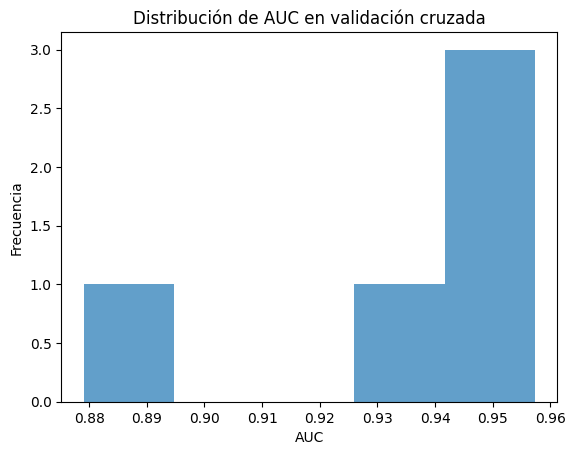

In [241]:
# Importamos las librerías necesarias para la validación cruzada y la visualización
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Realizamos la validación cruzada utilizando la métrica AUC
# cross_val_score entrena y evalúa el modelo en diferentes particiones de los datos
auc_scores = cross_val_score(clf, x, y, cv=5, scoring='roc_auc')

# Imprimimos los AUC scores obtenidos en cada partición (fold)
print("AUC scores for each fold:", auc_scores)

# Calculamos e imprimimos la media de los AUC scores
print("Mean AUC:", auc_scores.mean())

# Visualizamos la distribución de los AUC scores utilizando un histograma
plt.hist(auc_scores, bins=5, alpha=0.7)
plt.title("Distribución de AUC en validación cruzada")
plt.xlabel("AUC")
plt.ylabel("Frecuencia")
plt.show()


### 3.7. INTERPRETABILITY

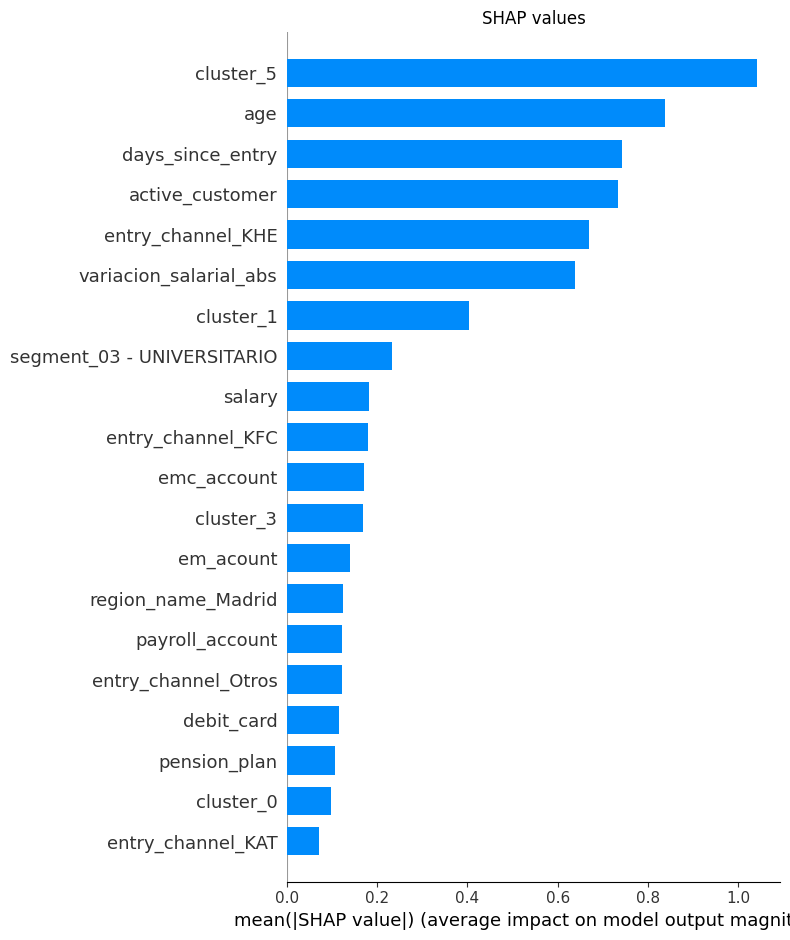

Las 5 features más importantes según los valores SHAP son:
cluster_5: 1.0413
age: 0.8377
days_since_entry: 0.7420
active_customer: 0.7339
entry_channel_KHE: 0.6693


In [242]:
# Se crea un objeto explainer utilizando TreeExplainer de SHAP para el modelo entrenado
explainer = shap.TreeExplainer(modelo)

# Se calculan los valores SHAP para el conjunto de prueba (df_X_test)
# Los valores SHAP miden la contribución de cada característica a la predicción del modelo
shap_values = explainer.shap_values(df_X_test)

# Se establece el título del gráfico
plt.title('SHAP values')

# Se genera un gráfico de resumen de los valores SHAP en forma de barra, mostrando las 20 características más importantes
shap.summary_plot(shap_values, df_X_test, plot_type="bar", max_display=20)

# Se calcula la importancia promedio de cada característica en términos absolutos
# Esto ayuda a identificar las características más influyentes en las predicciones del modelo
importancia_shap = pd.DataFrame({
    'feature': df_X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

# Se seleccionan las 5 características más importantes
top_features = importancia_shap.head(5)

# Se imprimen las 5 características principales junto con su importancia
print("Las 5 features más importantes según los valores SHAP son:")
for i, row in top_features.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")

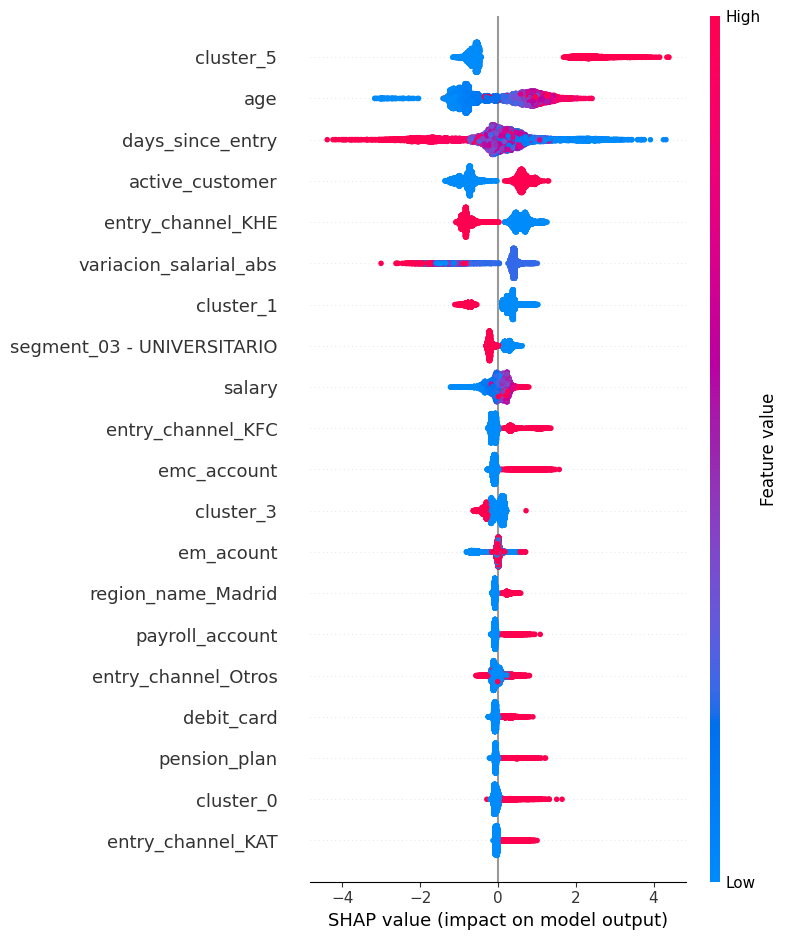

In [243]:
# Generamos el gráfico de resumen de los valores SHAP
# Este gráfico muestra la importancia de cada característica en las predicciones del modelo
shap.summary_plot(shap_values, df_X_test)

### 3.8. Matriz de confusion 

In [244]:
# Convertimos las predicciones del conjunto de test en un DataFrame
y_pred_test2 = pd.DataFrame(y_pred_test)

# Seleccionamos la segunda columna que contiene las probabilidades de la clase positiva
y_pred_test2 = y_pred_test2[1]

# Mostramos las probabilidades de la clase positiva
y_pred_test2

0       0.005469
1       0.000851
2       0.001021
3       0.000340
4       0.000067
          ...   
9837    0.000045
9838    0.000483
9839    0.031037
9840    0.379731
9841    0.000631
Name: 1, Length: 9842, dtype: float64

In [245]:
# Convertimos las probabilidades de predicción en etiquetas binarias (0 o 1)
# Si la probabilidad es mayor o igual a 0.5, se asigna 1, de lo contrario se asigna 0
y_pred_test2 = (y_pred_test2 >= 0.5).astype(int)

# Mostramos las etiquetas binarias resultantes
y_pred_test2

0       0
1       0
2       0
3       0
4       0
       ..
9837    0
9838    0
9839    0
9840    0
9841    0
Name: 1, Length: 9842, dtype: int32

In [246]:
# Imprimimos las primeras 5 observaciones de y_test
print("y_test:", y_test[:5])

# Imprimimos las primeras 5 predicciones de y_pred_test2
print("y_pred_test:", y_pred_test2[:5])

y_test: 177732    0.0
339658    0.0
161123    0.0
239184    0.0
5394      0.0
Name: tiene_prod_finan_lead1, dtype: float64
y_pred_test: 0    0
1    0
2    0
3    0
4    0
Name: 1, dtype: int32


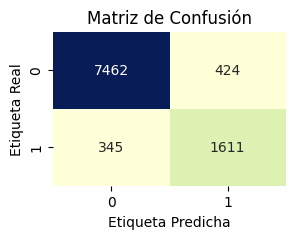

In [247]:
# Creamos la matriz de confusión utilizando las etiquetas reales (y_test) y las etiquetas predichas (y_pred_test2)
cm = metrics.confusion_matrix(y_test, y_pred_test2)

# Configuramos el tamaño de la figura para el gráfico de la matriz de confusión
plt.figure(figsize=(3, 2))

# Generamos un mapa de calor (heatmap) para visualizar la matriz de confusión
# Utilizamos la función heatmap de seaborn para crear el gráfico
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False)

# Creamos el gráfico
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Real')

# Mostramos el gráfico
plt.show()

### 3.9. Curva ROC

In [248]:
# Convertimos las predicciones del conjunto de entrenamiento en un DataFrame
y_pred_train2 = pd.DataFrame(y_pred_train)

# Seleccionamos la segunda columna que contiene las probabilidades de la clase positiva
y_pred_train2 = y_pred_train2[1]

# Mostramos las probabilidades de la clase positiva
y_pred_train2

0        0.012654
1        0.129677
2        0.000251
3        0.001797
4        0.000075
           ...   
22958    0.000265
22959    0.398767
22960    0.000772
22961    0.788003
22962    0.052924
Name: 1, Length: 22963, dtype: float64

In [249]:
# Convertimos las probabilidades de predicción en etiquetas binarias (0 o 1)
# Si la probabilidad es mayor o igual a 0.5, se asigna 1, de lo contrario se asigna 0
y_pred_train2 = (y_pred_train2 >= 0.5).astype(int)

# Mostramos las etiquetas binarias resultantes
y_pred_train2

0        0
1        0
2        0
3        0
4        0
        ..
22958    0
22959    0
22960    0
22961    1
22962    0
Name: 1, Length: 22963, dtype: int32

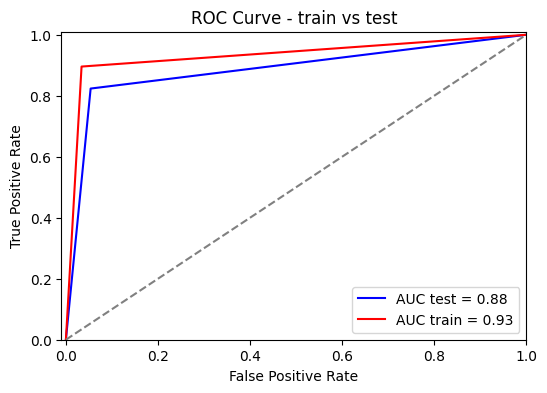

In [250]:
# Calculamos las métricas ROC para el conjunto de test
fpr_test, tpr_test, threshold_test = metrics.roc_curve(y_test, y_pred_test2)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

# Calculamos las métricas ROC para el conjunto de entrenamiento
fpr_train, tpr_train, threshold_train = metrics.roc_curve(y_train, y_pred_train2)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

# Configuramos el tamaño de la figura para el gráfico de la curva ROC
plt.figure(figsize=(6, 4))

# Graficamos la curva ROC para el conjunto de test
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC test = %0.2f' % roc_auc_test)

# Graficamos la curva ROC para el conjunto de entrenamiento
plt.plot(fpr_train, tpr_train, 'r', label = 'AUC train = %0.2f' % roc_auc_train)

# Creamos el gráfico
plt.title('ROC Curve - train vs test')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

# Mostramos el gráfico
plt.show()

### 3.10. Predict

In [251]:
# Realizamos la predicción en el dataset de predicción (df_pred_finan)
# Utilizamos el método predict para obtener las predicciones en formato binario (0 o 1)
pred = modelo.predict(df_pred_finan)

# Utilizamos el método predict_proba para obtener las probabilidades de predicción
# Esto nos da las probabilidades de pertenecer a cada clase (0 o 1)
pred_proba = modelo.predict_proba(df_pred_finan)

# Imprimimos un mensaje indicando que el resultado de la predicción está en formato array
# Mostramos las probabilidades de predicción
print(f' El resultado del la predicción esta en formato array', '\n',  pred_proba)

 El resultado del la predicción esta en formato array 
 [[8.79914201e-01 1.20085799e-01]
 [9.60607305e-01 3.93926947e-02]
 [9.88786007e-01 1.12139929e-02]
 ...
 [9.99075761e-01 9.24239453e-04]
 [9.95658837e-01 4.34116318e-03]
 [9.96458263e-01 3.54173744e-03]]


In [252]:
# Seleccionamos el ID del cliente del dataframe df_ids_predecir_finan
customer_id = df_ids_predecir_finan['pk_cid']

In [253]:
# Convertimos las probabilidades de predicción en un DataFrame
# Esto nos permite visualizar y manipular las probabilidades de predicción de manera más conveniente
pred_proba = pd.DataFrame(pred_proba)

# Mostramos el DataFrame resultante que contiene las probabilidades de predicción
pred_proba

,0,1
0,0.879914,0.120086
1,0.960607,0.039393
2,0.988786,0.011214
3,0.114313,0.885687
4,0.327405,0.672595
...,...,...
436591,0.989754,0.010246
436592,0.998867,0.001133
436593,0.999076,0.000924
436594,0.995659,0.004341


In [254]:
# Creamos un dataframe vacío para almacenar las predicciones y las probabilidades
df_prediccion_finan = pd.DataFrame()

# Asignamos el ID del cliente al dataframe
df_prediccion_finan['Customer_ID'] = customer_id

# Asignamos las predicciones al dataframe
df_prediccion_finan['prediccion'] = pred

# Asignamos las probabilidades de predicción al dataframe
df_prediccion_finan['%_proba'] = pred_proba[1]

# Imprimimos un mensaje indicando que podemos ver la predicción de cada cliente junto a la probabilidad de la predicción
print('Podemos ver la prediccion de cada cliente junto a la probabilidad de la prediccion')

# Mostramos el dataframe resultante
df_prediccion_finan


Podemos ver la prediccion de cada cliente junto a la probabilidad de la prediccion


,Customer_ID,prediccion,%_proba
0,16063,0.0,0.120086
1,16203,0.0,0.039393
2,16502,0.0,0.011214
3,17457,1.0,0.885687
4,17590,1.0,0.672595
...,...,...,...
436591,1553685,0.0,0.010246
436592,1553686,0.0,0.001133
436593,1553687,0.0,0.000924
436594,1553688,0.0,0.004341


In [255]:
# Filtramos el dataframe 'df_prediccion_finan' para quedarnos solo con las predicciones positivas
# Esto significa que solo conservamos las filas donde la columna 'prediccion' tiene un valor de 1.0
df_prediccion_finan = df_prediccion_finan[df_prediccion_finan['prediccion'] == 1.0]

### 3.11. Guarda predicciones

In [256]:
# Guardamos el dataframe de predicciones en un archivo CSV
# Esto permite almacenar las predicciones realizadas por el modelo en un archivo para su posterior análisis o uso
df_prediccion_cuenta.to_csv('reports/df_prediccion_cuenta.csv')

In [257]:
# Guardamos el dataframe de predicciones en un archivo CSV
# Esto permite almacenar las predicciones realizadas por el modelo en un archivo para su posterior análisis o uso
df_prediccion_ahorro.to_csv('reports/df_prediccion_ahorro.csv')

In [258]:
# Guardamos el dataframe de predicciones en un archivo CSV
# Esto permite almacenar las predicciones realizadas por el modelo en un archivo para su posterior análisis o uso
df_prediccion_finan.to_csv('reports/df_prediccion_finan.csv')

In [259]:
print(len(df_prediccion_cuenta))
print(len(df_prediccion_ahorro))
print(len(df_prediccion_finan))

80051
13466
19441


## 4. Obtener Escenarios de Clientes

In [260]:
# Definimos los niveles de probabilidad para cada escenario
# Estos niveles determinan el umbral de probabilidad para seleccionar clientes en cada escenario
escenarios = {
    "Escenario Conservador": 0.9,  # Mayor seguridad, mayor umbral de probabilidad
    "Escenario Moderado": 0.8,  # Equilibrado
    "Escenario Agresivo": 0.7   # Mayor riesgo, menor umbral de probabilidad
}

# Definimos las ganancias asociadas a cada tipo de producto
ganancias = {
    "cuenta": 10,
    "ahorro": 40,
    "finan": 60
}

# Función para optimizar la selección de clientes en base a un umbral de probabilidad
def optimizar_seleccion(df_cuenta, df_ahorro, df_finan, umbral, num_clientes=10000):
    # Añadimos una columna 'producto' y 'ganancia' a cada dataframe
    df_cuenta["producto"] = "cuenta"
    df_cuenta["ganancia"] = ganancias["cuenta"]
    df_ahorro["producto"] = "ahorro"
    df_ahorro["ganancia"] = ganancias["ahorro"]
    df_finan["producto"] = "finan"
    df_finan["ganancia"] = ganancias["finan"]
    
    # Unimos los tres dataframes en uno solo
    df_total = pd.concat([df_cuenta, df_ahorro, df_finan], ignore_index=True)
    
    # Calculamos el valor esperado de ganancia para cada cliente
    df_total["valor_esperado"] = df_total["%_proba"] * df_total["ganancia"]
    
    # Filtramos los clientes que superan el umbral de probabilidad
    df_filtrado = df_total[df_total["%_proba"] > umbral]
    
    # Ordenamos los clientes filtrados por valor esperado de ganancia en orden descendente
    df_ordenado = df_filtrado.sort_values(by="valor_esperado", ascending=False)
    
    # Seleccionamos los top N clientes con mayor valor esperado de ganancia
    top_n = df_ordenado.head(num_clientes)
    
    # Calculamos los umbrales óptimos de probabilidad para cada producto
    umbrales_optimos = top_n.groupby("producto")["%_proba"].min().to_dict()
    
    # Contamos la cantidad de clientes seleccionados por producto
    cantidad_seleccionados = top_n["producto"].value_counts().to_dict()
    
    # Calculamos las ganancias totales sumando las ganancias de cada producto
    ganancias_totales = sum(cantidad_seleccionados.get(producto, 0) * ganancias[producto] for producto in ganancias.keys())
    
    return umbrales_optimos, ganancias_totales

# Creamos un dataframe vacío para almacenar los resultados de cada escenario
df_resultados = pd.DataFrame(columns=["Escenario", "cuenta", "ahorro", "finan", "ganancia_total"])

# Iteramos sobre los escenarios y calculamos los umbrales y ganancias para cada uno
for nombre_escenario, umbral in escenarios.items():
    umbrales, ganancia_total = optimizar_seleccion(df_prediccion_cuenta, df_prediccion_ahorro, df_prediccion_finan, umbral)
    fila = {
        "Escenario": nombre_escenario, 
        "cuenta": umbrales.get("cuenta", 0), 
        "ahorro": umbrales.get("ahorro", 0), 
        "finan": umbrales.get("finan", 0),
        "ganancia_total": ganancia_total
    }
    df_resultados = pd.concat([df_resultados, pd.DataFrame([fila])], ignore_index=True)

# Mostramos el dataframe con los resultados de cada escenario
print(df_resultados)



               Escenario    cuenta    ahorro     finan ganancia_total
0  Escenario Conservador  0.961759  0.900309  0.900173         174300
1     Escenario Moderado  0.977023  0.800087  0.800009         392860
2     Escenario Agresivo  0.000000  0.857889  0.700022         585880


In [261]:
# Guardamos el dataframe de resultados en un archivo CSV
# Esto permite almacenar los resultados de los escenarios de predicción en un archivo para su posterior análisis o uso
df_resultados.to_csv("reports/escenarios_predicciones.csv")